In [1]:
install.packages("sandwich")
install.packages("coefplot")
install.packages("lmtest")


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'sandwich' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpMdXgCA\downloaded_packages


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'coefplot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpMdXgCA\downloaded_packages


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'lmtest' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'lmtest'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\Kaiyan Zhang\AppData\Local\R\win-library\4.4\00LOCK\lmtest\libs\x64\lmtest.dll to C:\Users\Kaiyan Zhang\AppData\Local\R\win-library\4.4\lmtest\libs\x64\lmtest.dll: Permission denied"
Warning message:
"restored 'lmtest'"



The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpMdXgCA\downloaded_packages


In [2]:
library(geojsonio)
library(tidyverse)
library(ggplot2)
library(tidyr)
library(dplyr)
library("knitr")
library(broom)
library(stargazer)
library(units)
library(sf)
library(car)
library(sandwich)
library(coefplot)
library(lmtest)


Warning message:
"package 'geojsonio' was built under R version 4.4.2"
Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: 'geojsonio'


The following object is masked from 'package:base':

    pretty


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


udunits database from

In [3]:
# Read in the data
census_index_crime <- st_read("census_index_crime.geojson") |>
    mutate(across(c(immigrant_prop, education_prop, mean_land_value,income), as.double))|>
    na.omit()|>
    glimpse()

Reading layer `census_index_crime' from data source 
  `C:\Users\Kaiyan Zhang\Desktop\econ326\census_index_crime.geojson' 
  using driver `GeoJSON'
Simple feature collection with 993 features and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -123.2242 ymin: 49.19853 xmax: -123.0229 ymax: 49.31408
Geodetic CRS:  WGS 84


Warning message:
"There were 4 warnings in `stopifnot()`.
The first warning was:
ℹ In argument: `across(...)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings."


Rows: 989
Columns: 19
$ name                 <chr> "59150307", "59150308", "59150309", "59150310", "…
$ households           <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174,…
$ dwellings            <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189,…
$ population           <int> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506…
$ population_density   <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, 6…
$ region               <chr> "Vancouver", "Vancouver", "Vancouver", "Vancouver…
$ area_sq_km           <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.08…
$ age                  <int> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 510…
$ income               <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, 0.74…
$ immigrant_prop       <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0.404…
$ education_prop       <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0.253…
$ school_index         <dbl> 1.074675, 1.252273, 1.426336, 2.441091, 1.543095,…
$ light_index     

In [4]:
census_save <- census_index_crime|>
    st_drop_geometry()

write.csv(census_save, "census_index_crime.csv")


In [5]:
fn_residuals <- function(data, dependent_vars, independent_var) {
  
residuals_list <- list() #empty accumulator list

# looping through each variable and calcualting residuals
  for (var in dependent_vars) {
   formula <- as.formula(paste(var, "~", independent_var)) # https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/formula
    model <- lm(formula, data = data)
    residuals_list[[var]] <- resid(model) # extracting residuals and assigning to empty list
  }
  
  residuals_df <- as.data.frame(residuals_list)
  colnames(residuals_df) <- paste0("residual_", dependent_vars)

residuals_df <- cbind(residuals_df, data[dependent_vars]) |>
select(!geometry)

 return(residuals_df)
}


Rows: 989
Columns: 2
$ residual_bus_index <dbl> -1.62317900, -1.48040693, -1.12875315, 0.67312399, …
$ bus_index          <dbl> 1.314003, 1.455674, 1.812310, 3.605736, 1.782943, 1…


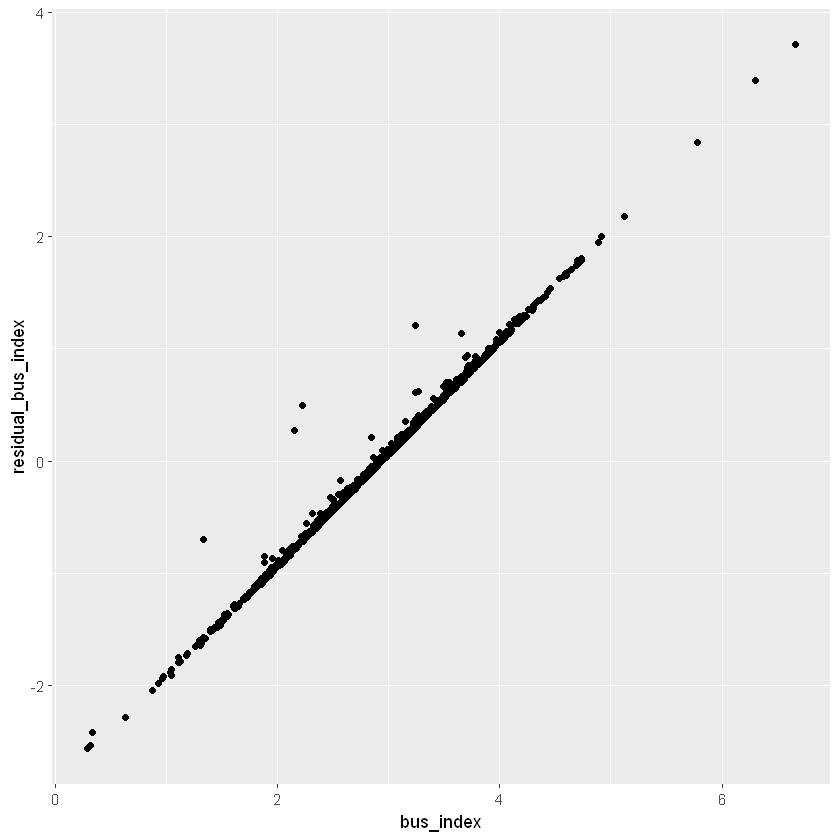

In [6]:
# test that the function works properly

residuals_bus <- fn_residuals(data = census_index_crime, dependent_var = "bus_index", independent_var = "mean_land_value")
glimpse(residuals_bus)

test_res <- residuals_bus |>
ggplot(aes(x=bus_index, y=residual_bus_index)) +geom_point()

test_res

In [7]:
dependent_vars <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
residuals_df <- fn_residuals(census_index_crime, dependent_vars, "crime_rate")

In [8]:
glimpse(residuals_df)

Rows: 989
Columns: 16
$ residual_mean_land_value      <dbl> -0.9850139, -0.9110909, -1.1870712, -0.7…
$ residual_school_index         <dbl> -1.55033886, -1.36752701, -1.19754199, -…
$ residual_light_index          <dbl> -1.03450149, -1.15903864, -0.78886803, -…
$ residual_bus_index            <dbl> -1.59937960, -1.42126915, -1.09313819, 0…
$ residual_cultural_space_index <dbl> -0.92630452, -0.80803867, -0.71491957, -…
$ residual_income               <dbl> 0.178902630, 0.199103749, 0.115249759, -…
$ residual_immigrant_prop       <dbl> -0.156853743, -0.132295534, -0.063049582…
$ residual_education_prop       <dbl> -0.0274468049, -0.0551394647, -0.0202477…
$ mean_land_value               <dbl> 0.9556436, 1.0139412, 0.7501839, 1.19761…
$ school_index                  <dbl> 1.074675, 1.252273, 1.426336, 2.441091, …
$ light_index                   <dbl> 2.751678, 2.575631, 2.986096, 3.239346, …
$ bus_index                     <dbl> 1.314003, 1.455674, 1.812310, 3.605736, …
$ cultural_space_i

In [9]:

residuals_long <- residuals_df |>
  pivot_longer(
    cols = starts_with("residual_"), names_to = "residual_type", values_to = "residual_value") |>
  mutate(x_value = case_when(
    residual_type == "residual_mean_land_value" ~ mean_land_value,
    residual_type == "residual_school_index" ~ school_index,
    residual_type == "residual_light_index" ~ light_index,
    residual_type == "residual_bus_index" ~ bus_index,
    residual_type == "residual_cultural_space_index" ~ cultural_space_index,
    residual_type == "residual_income" ~ income,
    residual_type == "residual_immigrant_prop" ~ immigrant_prop,
    residual_type == "residual_education_prop" ~ education_prop
  ))

In [10]:
glimpse(residuals_long)

Rows: 7,912
Columns: 11
$ mean_land_value      <dbl> 0.9556436, 0.9556436, 0.9556436, 0.9556436, 0.955…
$ school_index         <dbl> 1.074675, 1.074675, 1.074675, 1.074675, 1.074675,…
$ light_index          <dbl> 2.751678, 2.751678, 2.751678, 2.751678, 2.751678,…
$ bus_index            <dbl> 1.314003, 1.314003, 1.314003, 1.314003, 1.314003,…
$ cultural_space_index <dbl> 1.286579, 1.286579, 1.286579, 1.286579, 1.286579,…
$ income               <dbl> 0.90965, 0.90965, 0.90965, 0.90965, 0.90965, 0.90…
$ immigrant_prop       <dbl> 0.2610759, 0.2610759, 0.2610759, 0.2610759, 0.261…
$ education_prop       <dbl> 0.3085443, 0.3085443, 0.3085443, 0.3085443, 0.308…
$ residual_type        <chr> "residual_mean_land_value", "residual_school_inde…
$ residual_value       <dbl> -0.98501394, -1.55033886, -1.03450149, -1.5993796…
$ x_value              <dbl> 0.9556436, 1.0746748, 2.7516784, 1.3140034, 1.286…


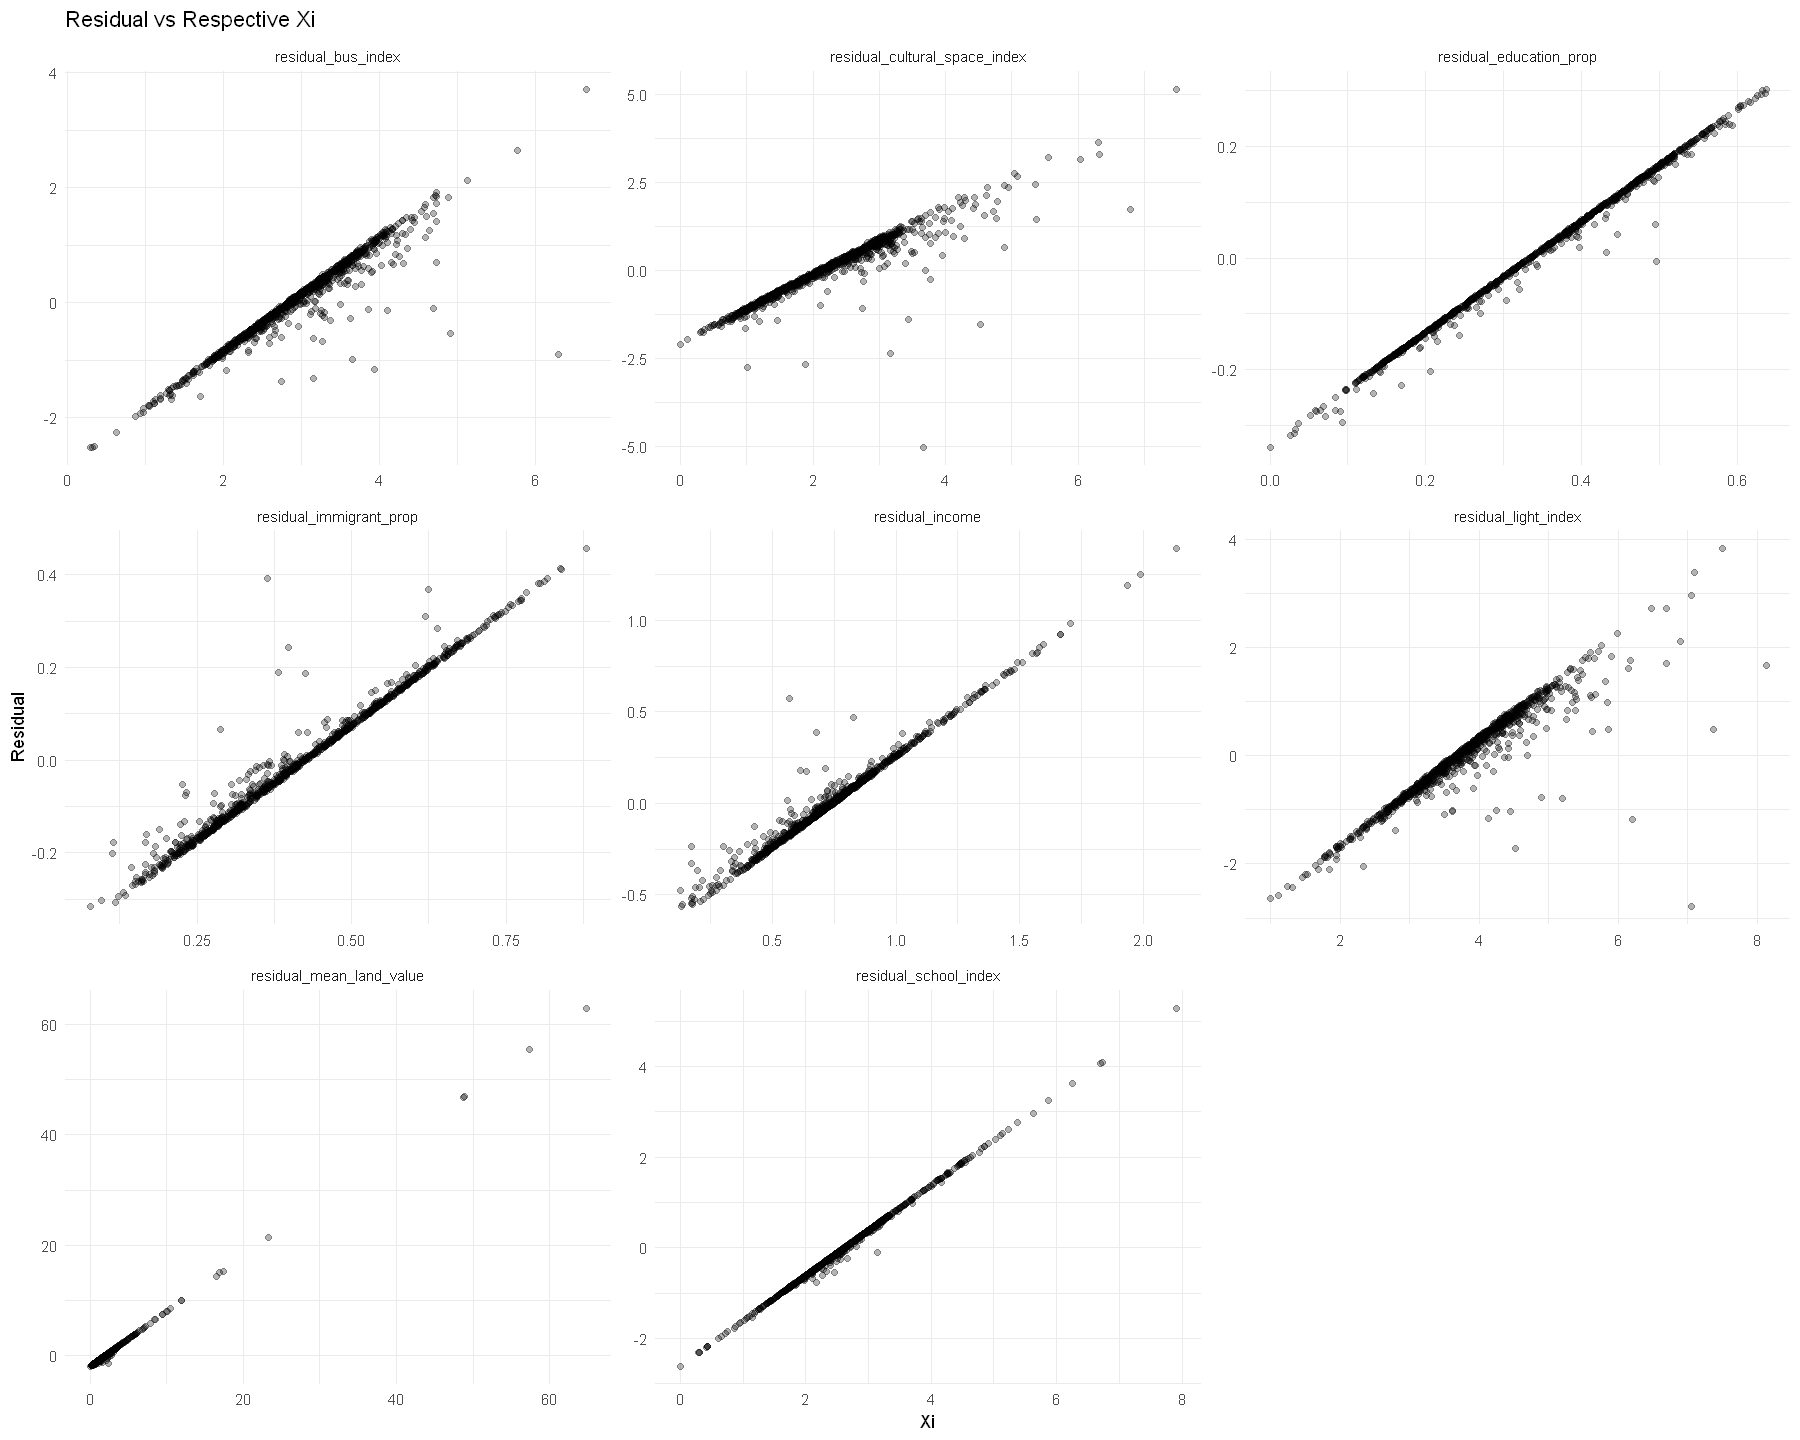

In [11]:
options(repr.plot.width = 15, repr.plot.height = 12)

residuals_plot <- ggplot(residuals_long, aes(x = x_value, y = residual_value)) +
  geom_point(alpha = 0.3) +
  facet_wrap(~ residual_type, scales = "free") +
  labs(
    title = "Residual vs Respective Xi",
    x = "Xi",
    y = "Residual") +
  theme_minimal()

residuals_plot

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `model = list(lm(residual_value ~ x_value, data = cur_data()))`.
ℹ In group 1: `residual_type = "residual_bus_index"`.
Caused by warning:
! `cur_data()` was deprecated in dplyr 1.1.0.
ℹ Please use `pick()` instead."
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


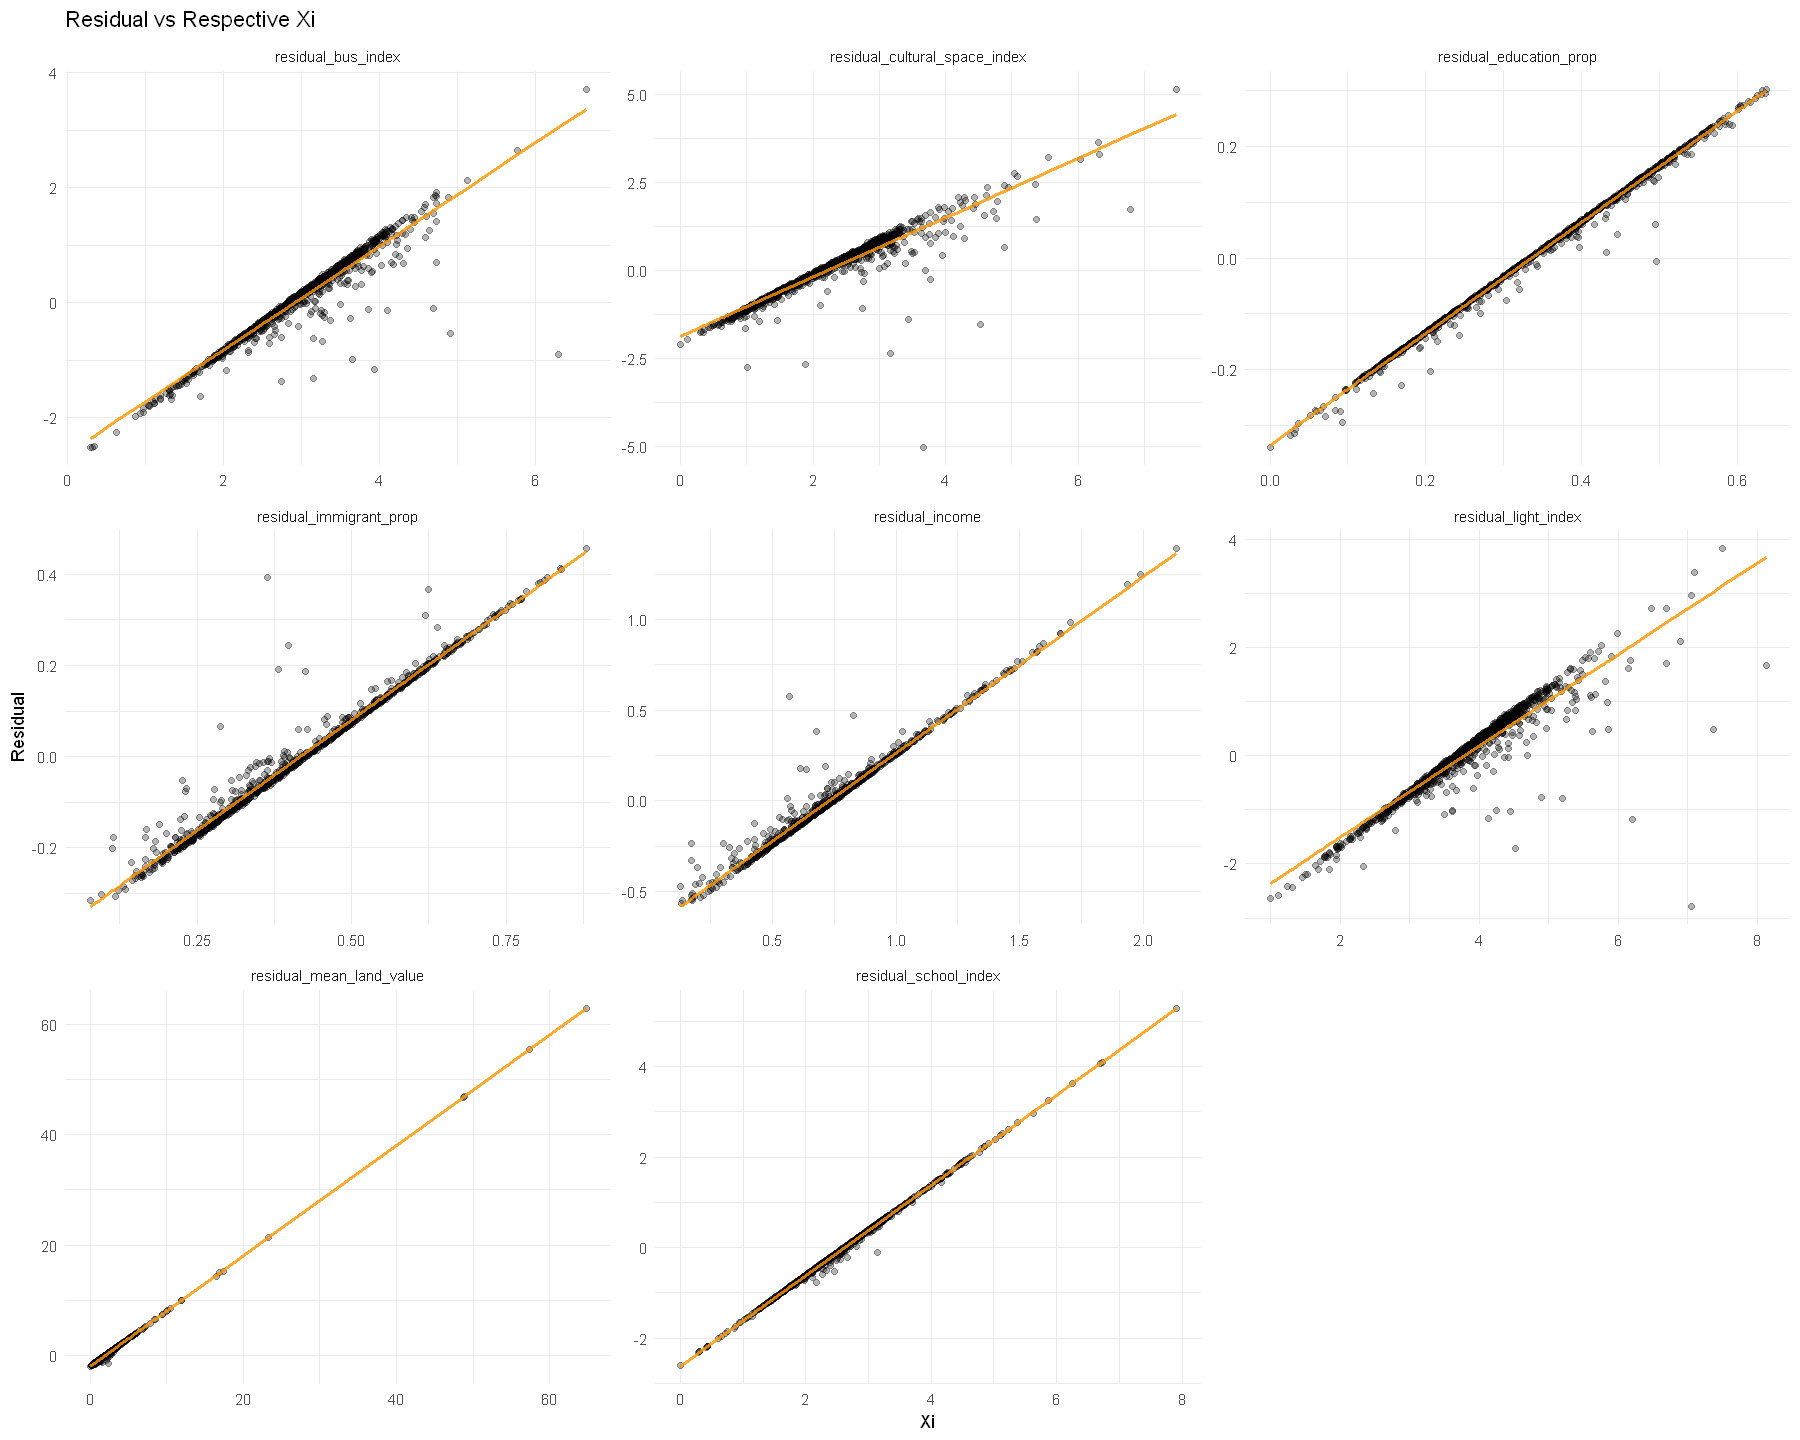

In [12]:
residuals_long  <- residuals_long |>
  group_by(residual_type) |>
  mutate(
    model = list(lm(residual_value ~ x_value, data = cur_data())),
    fitted_values = predict(model[[1]], newdata = data.frame(x_value = x_value))
  ) |>
  ungroup()

ggplot(residuals_long, aes(x = x_value, y = residual_value)) +
  geom_point(alpha=0.3) +
  geom_line(aes(y = fitted_values), color = "#ff9500", size=1, alpha=0.8) +  
  facet_wrap(~ residual_type, scales = "free") +
  labs(
    title = "Residual vs Respective Xi",
    x = "Xi",
    y = "Residual"
  ) +
  theme_minimal()

In [13]:
regressors <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
residuals_df <- fn_residuals(census_index_crime, regressors, "crime_rate") |>
mutate(crime_rate = census_index_crime$crime_rate) 

glimpse(residuals_df)


colnames(residuals_df)

Rows: 989
Columns: 17
$ residual_mean_land_value      <dbl> -0.9850139, -0.9110909, -1.1870712, -0.7…
$ residual_school_index         <dbl> -1.55033886, -1.36752701, -1.19754199, -…
$ residual_light_index          <dbl> -1.03450149, -1.15903864, -0.78886803, -…
$ residual_bus_index            <dbl> -1.59937960, -1.42126915, -1.09313819, 0…
$ residual_cultural_space_index <dbl> -0.92630452, -0.80803867, -0.71491957, -…
$ residual_income               <dbl> 0.178902630, 0.199103749, 0.115249759, -…
$ residual_immigrant_prop       <dbl> -0.156853743, -0.132295534, -0.063049582…
$ residual_education_prop       <dbl> -0.0274468049, -0.0551394647, -0.0202477…
$ mean_land_value               <dbl> 0.9556436, 1.0139412, 0.7501839, 1.19761…
$ school_index                  <dbl> 1.074675, 1.252273, 1.426336, 2.441091, …
$ light_index                   <dbl> 2.751678, 2.575631, 2.986096, 3.239346, …
$ bus_index                     <dbl> 1.314003, 1.455674, 1.812310, 3.605736, …
$ cultural_space_i

[1] "residual_mean_land_value"      "residual_school_index"        
 [3] "residual_light_index"          "residual_bus_index"           
 [5] "residual_cultural_space_index" "residual_income"              
 [7] "residual_immigrant_prop"       "residual_education_prop"      
 [9] "mean_land_value"               "school_index"                 
[11] "light_index"                   "bus_index"                    
[13] "cultural_space_index"          "income"                       
[15] "immigrant_prop"                "education_prop"               
[17] "crime_rate"

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(regressors)

  # Now:
  data %>% select(all_of(regressors))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


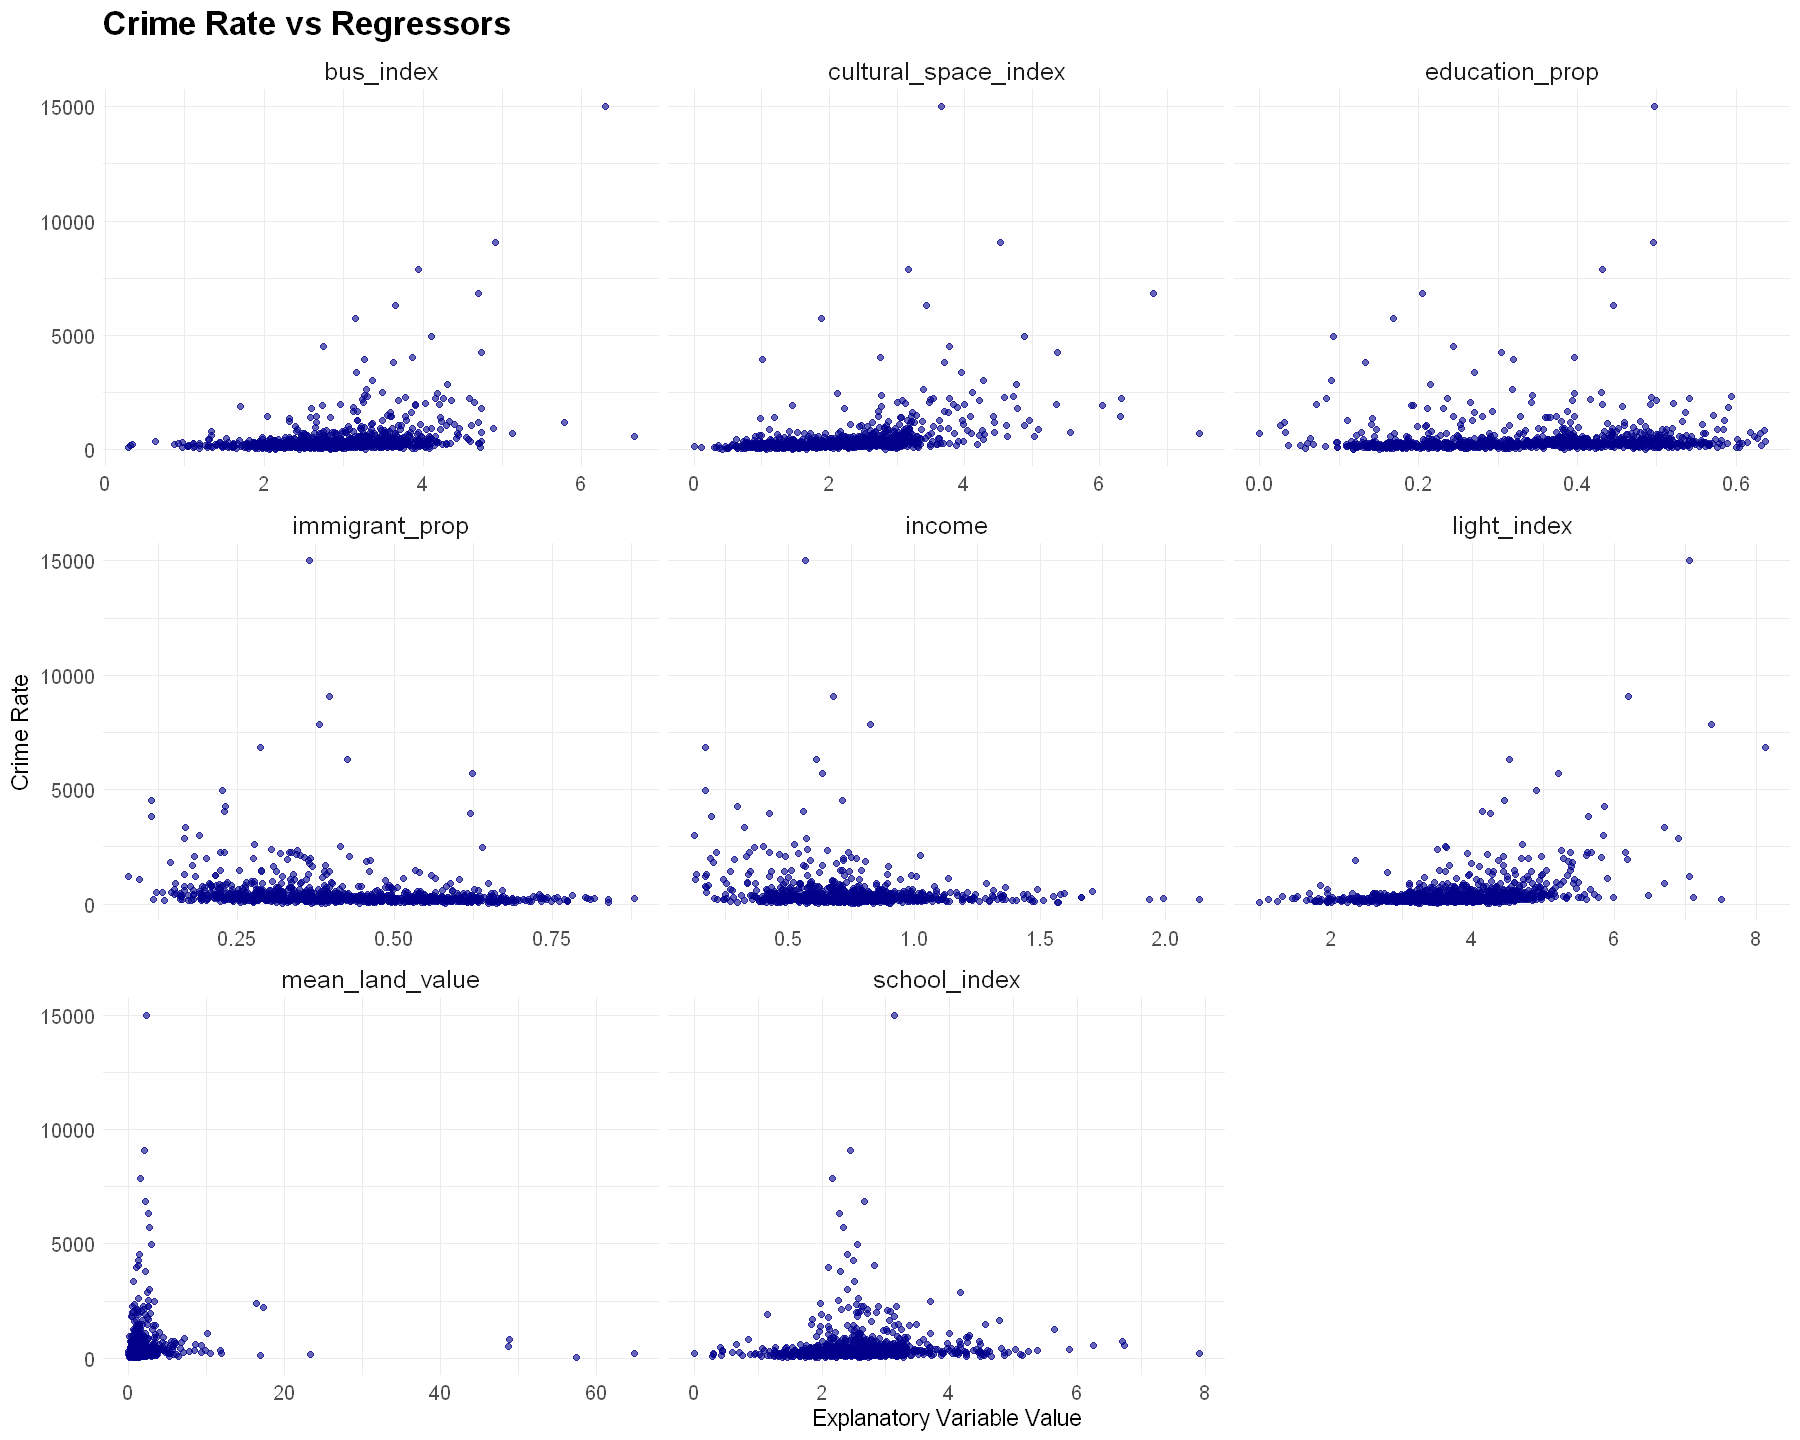

In [14]:
regressors <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')

long_data <- census_index_crime |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

variables_scatter <- ggplot(long_data, aes(x = value, y = crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "Crime Rate vs Regressors",
       x = "Explanatory Variable Value",
       y = "Crime Rate") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

variables_scatter

By eyeball method, it's clear that the data is itself heteoskedastic.

In [15]:
# Carry out all the simple regressions
outcome <- "crime_rate"

simple_regressions <- map(regressors, ~ lm(as.formula(paste(outcome, "~", .x)), data = census_index_crime))

names(simple_regressions) <- regressors

stargazer(simple_regressions, type = "text",
          title = "Simple Regression Results",
          dep.var.labels = c("Crime Rate"))


Simple Regression Results
                                                                   Dependent variable:                                     
                               --------------------------------------------------------------------------------------------
                                                                        Crime Rate                                         
                                  (1)        (2)         (3)         (4)         (5)         (6)         (7)        (8)    
---------------------------------------------------------------------------------------------------------------------------
mean_land_value                  6.156                                                                                     
                                (7.024)                                                                                    
                                                                                                         

`geom_smooth()` using formula = 'y ~ x'


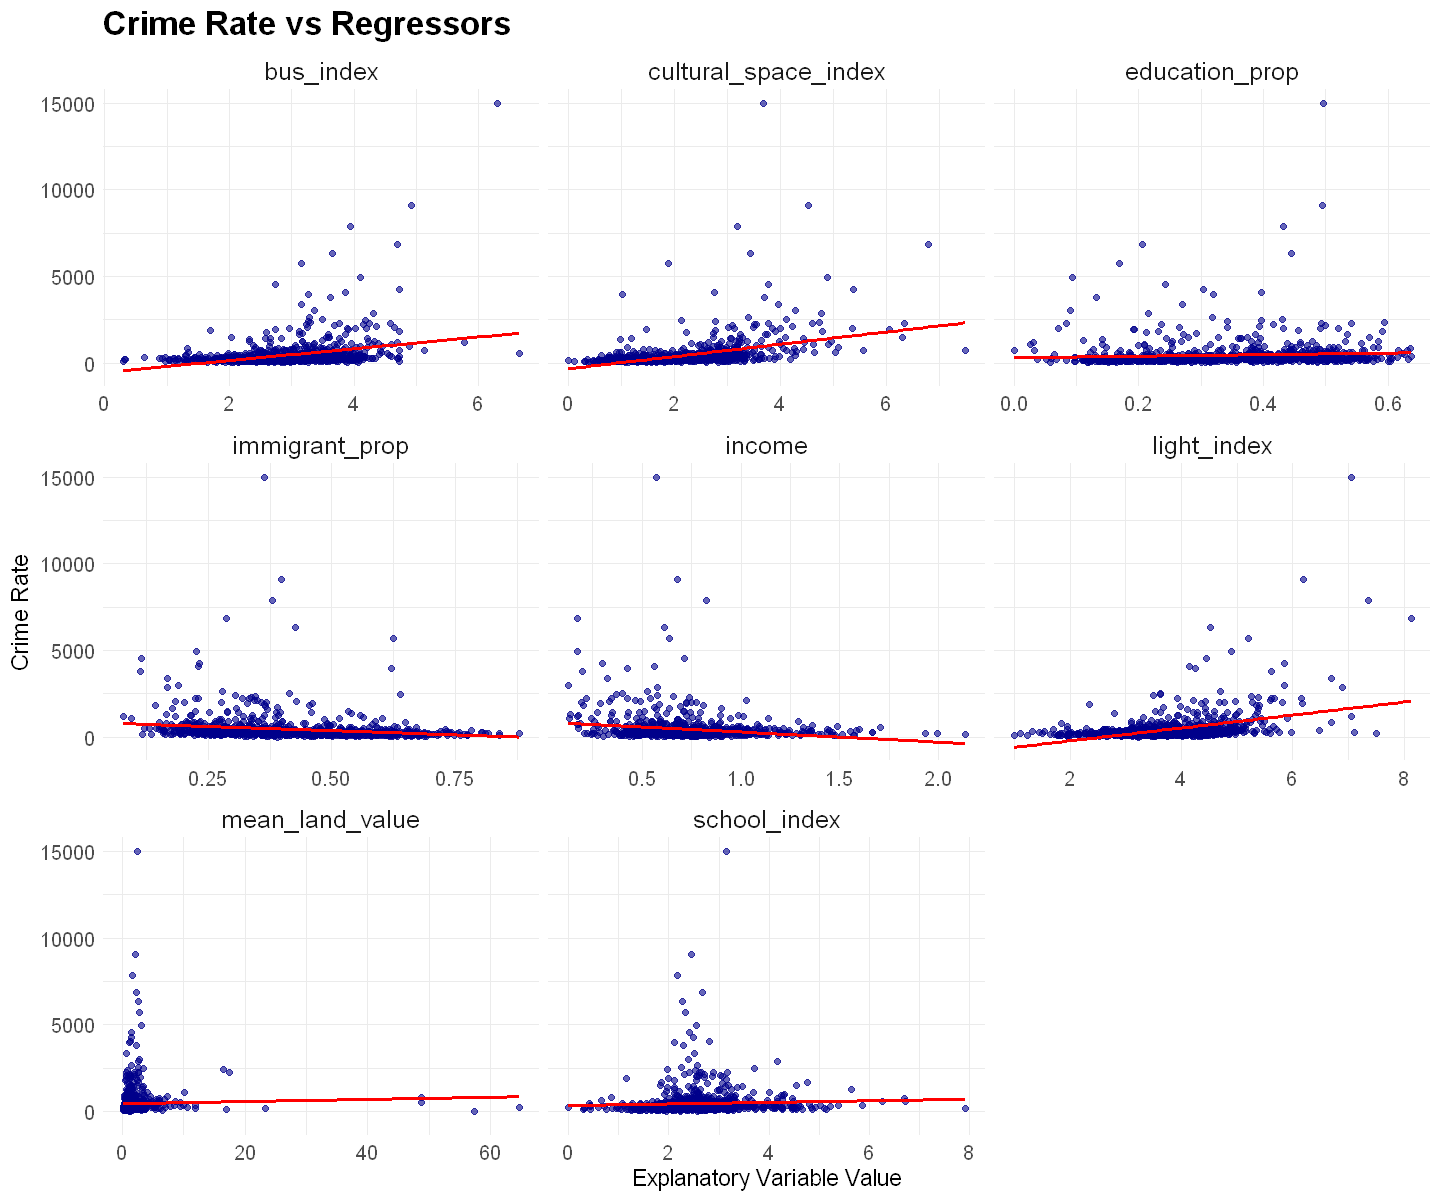

In [16]:
# Visualizing simple regressions
options(repr.plot.width = 12, repr.plot.height = 10)
simple_regression_plot <- variables_scatter +  geom_smooth(method = "lm", se = FALSE, color = "red") 

simple_regression_plot

In [17]:
# Test by running a model including all control
reg_all <- lm(crime_rate ~ mean_land_value + school_index + light_index + bus_index + cultural_space_index + 
    income + immigrant_prop + education_prop, data = census_index_crime)
    
stargazer(reg_all, type = "text",
          title = "Regression With All Variable Results",
          dep.var.labels = c("Crime Rate"))


Regression With All Variable Results
                         Dependent variable:    
                     ---------------------------
                             Crime Rate         
------------------------------------------------
mean_land_value                 7.986           
                               (6.161)          
                                                
school_index                 -288.336***        
                              (36.379)          
                                                
light_index                  373.969***         
                              (46.948)          
                                                
bus_index                      27.590           
                              (51.888)          
                                                
cultural_space_index         180.362***         
                              (44.134)          
                                                
income                       -2

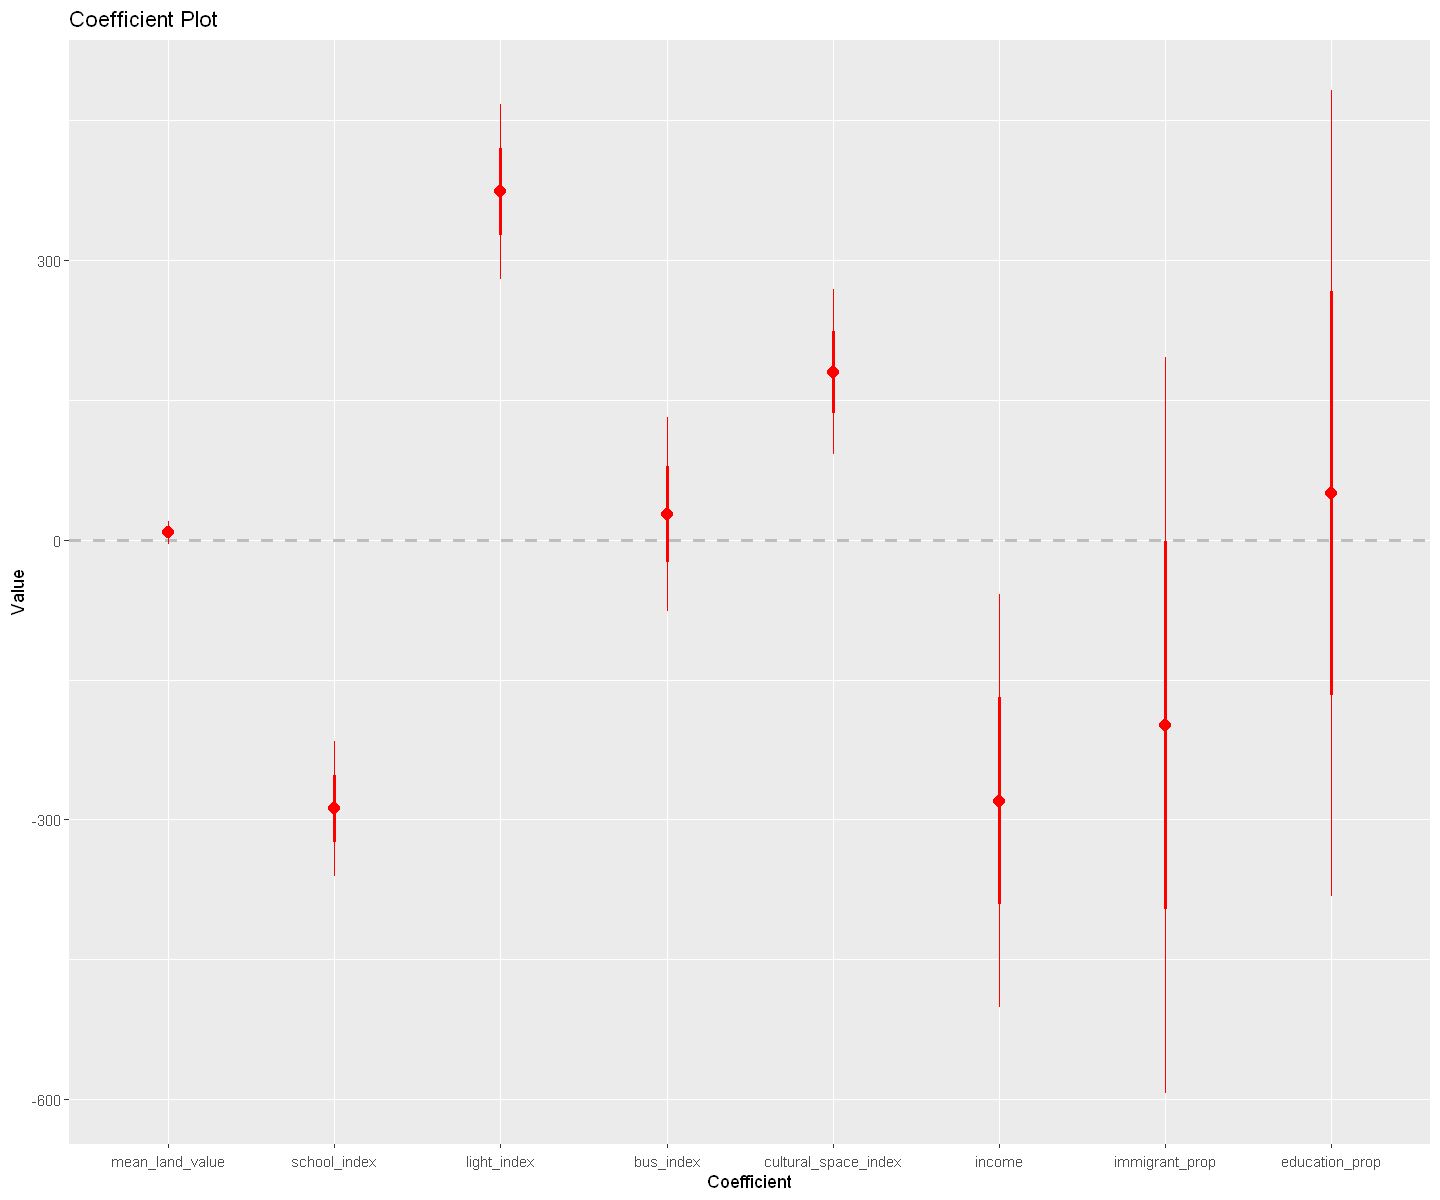

In [18]:
coefplot(reg_all, intercept = FALSE, horizontal = TRUE, color = "red")

The regression output above suggests that bus_index, immigrant_prop, and education_prop variables may be insignificant for having p-values > 0.1

In [19]:
# Examining the vif of the model
vif(reg_all, type = "terms")|>
tidy()

Warning message in tidy.numeric(vif(reg_all, type = "terms")):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
mean_land_value,1.023274
school_index,1.607963
light_index,3.238826
bus_index,3.080453
cultural_space_index,3.217783
income,1.401230
immigrant_prop,1.630053
education_prop,1.571709


In [20]:
# Predict y_hat
y_hat <- predict(reg_all)

In [21]:
# Carry out white's test
white <- lm(reg_all$residuals^2 ~ y_hat + I(y_hat^2))

stargazer(white, type = "text",
          title = "White's Test",
          dep.var.labels = c("Residual"))


White's Test
                        Dependent variable:    
                    ---------------------------
                             Residual          
-----------------------------------------------
y_hat                      -1,741.469**        
                             (734.848)         
                                               
I(y_hat2)                    3.609***          
                              (0.467)          
                                               
Constant                    -83,925.540        
                           (280,217.100)       
                                               
-----------------------------------------------
Observations                    989            
R2                             0.098           
Adjusted R2                    0.096           
Residual Std. Error  5,622,803.000 (df = 986)  
F Statistic           53.583*** (df = 2; 986)  
Note:               *p<0.1; **p<0.05; ***p<0.01


In [22]:
# Continuing on white's test
linearHypothesis(white, c("y_hat = 0", "I(y_hat^2) = 0"))

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,988,3.456141e+16,NA,NA,NA,NA
2,986,3.117329e+16,2,3.388127e+15,53.58262,8.113556e-23


The extremely small p-value suggests rejecting the null hypothesis that residuals are constant.
This means there is strong evidence of heteroskedasticity in the data. We need to use robust standard errors to resolve this issue.

In [23]:
reg1 <- lm(crime_rate ~ school_index + light_index + cultural_space_index + 
    income, data = census_index_crime)

stargazer(reg1, type = "text",
          title = "Regression With Significant Controls",
          dep.var.labels = c("Crime Rate"))


Regression With Significant Controls
                         Dependent variable:    
                     ---------------------------
                             Crime Rate         
------------------------------------------------
school_index                 -287.323***        
                              (34.776)          
                                                
light_index                  369.548***         
                              (36.862)          
                                                
cultural_space_index         217.168***         
                              (32.014)          
                                                
income                       -259.734***        
                              (97.443)          
                                                
Constant                     -479.589***        
                              (133.759)         
                                                
-------------------------------

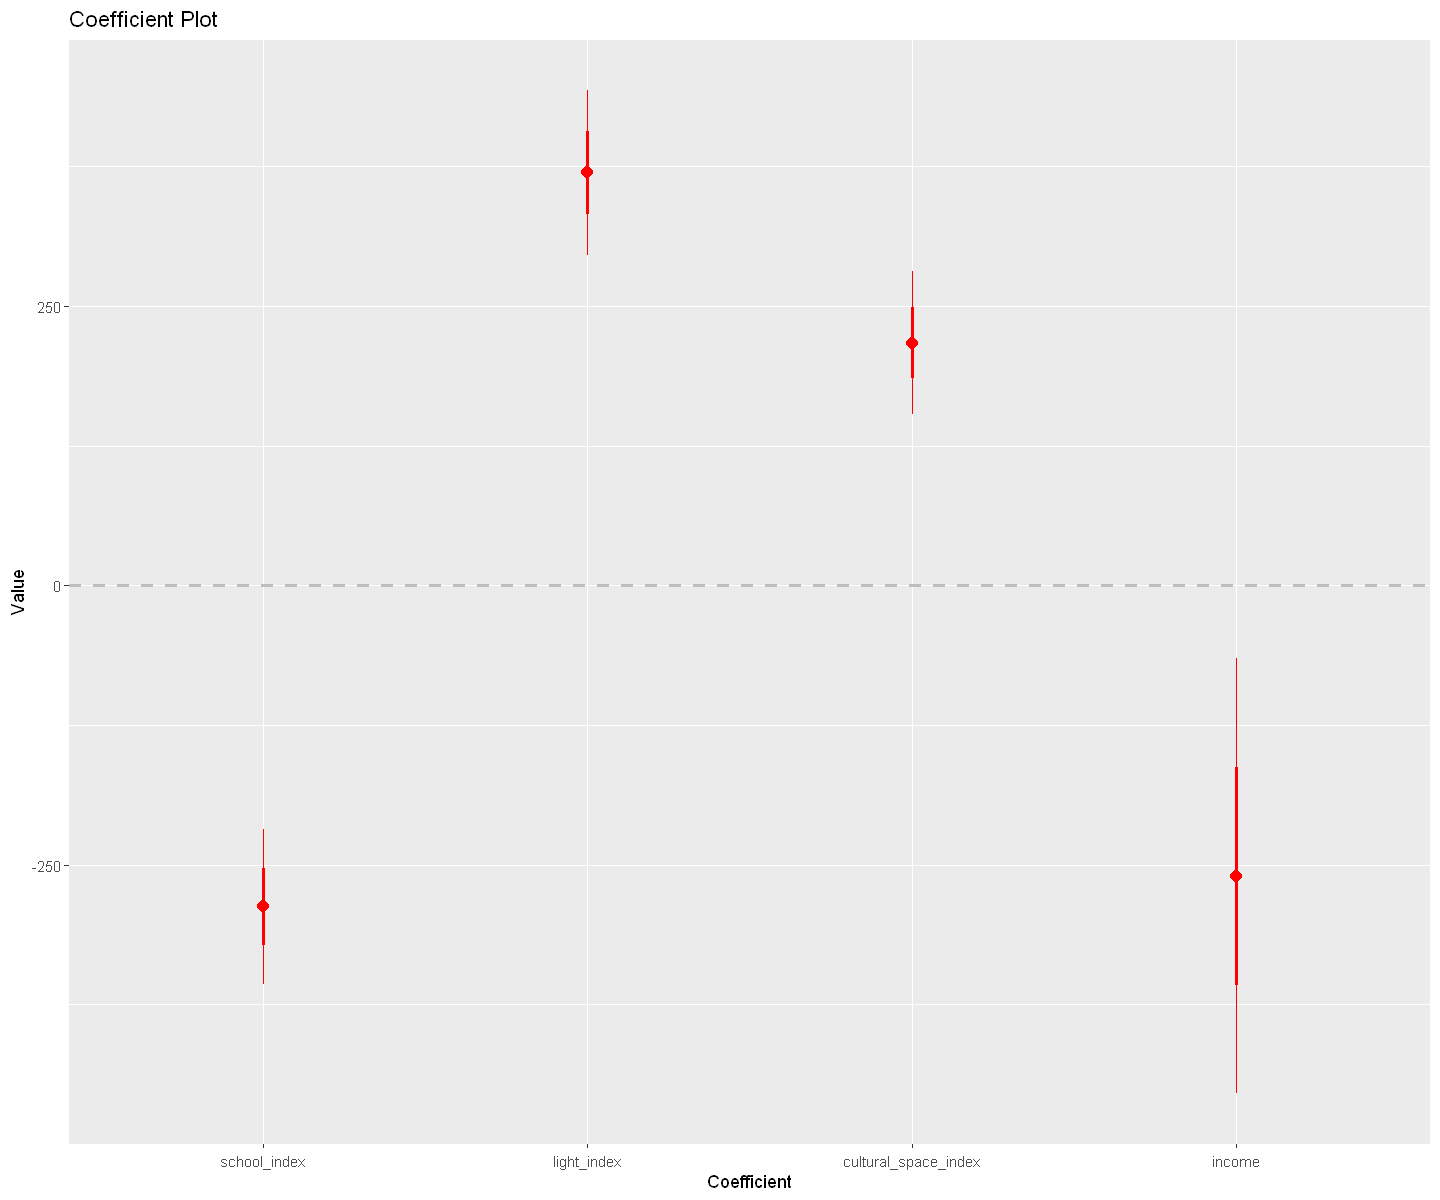

In [24]:
coefplot(reg1, intercept = FALSE, horizontal = TRUE, color = "red")

In [25]:
stargazer(simple_regressions, reg1, reg_all,
          type = "text", 
          title = "Regression Results",
          dep.var.labels = c("Crime Rate","Crime Rate"))


Regression Results
                                                                                                                               Dependent variable:                                                                                                           
                     ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                            Crime Rate                                                                                                          Crime Rate                   
                             (1)                 (2)                   (3)                      (4)                      (5)                      (6)                     (7)                    (8)                    (9

We want to make sure what made land_value and bus_index insignificant and school_index significant in our model with all variables, so we continue to run other models.

In [26]:
# Regressions with land_value always present
regressors_without_land_value <- c( 'school_index','light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_land_value <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ mean_land_value +", .x)), data = census_index_crime))

names(reg_with_land_value) <- regressors

stargazer(reg_with_land_value, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                     Dependent variable:                                                                                 
                     ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                          Crime Rate                                                                                     
                             (1)                 (2)                   (3)                     (4)                     (5)                     (6)                     (7)                   (8)         
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
# Regressions with school always present
regressors_without_school <- c( 'mean_land_value','light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_school <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ school_index +",  .x)), data = census_index_crime))

names(reg_with_school) <- regressors

stargazer(reg_with_school, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                       Dependent variable:                                                                                  
                     ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                           Crime Rate                                                                                       
                             (1)                 (2)                   (3)                      (4)                     (5)                      (6)                     (7)                    (8)         
----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
# Regressions with bus always present
regressors_without_bus <- c( 'mean_land_value','school_index','light_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_bus <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ bus_index +",  .x)), data = census_index_crime))

names(reg_with_bus) <- regressors

stargazer(reg_with_bus, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                           Dependent variable:                                                                                       
                     ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                Crime Rate                                                                                           
                               (1)                     (2)                     (3)                     (4)                      (5)                     (6)                     (7)                     (8)          
----------------------------------------------------------------------------------------------------------------------------

From results above, we may conclude that mean land value is itself statistically insignificant, school is statistically significant when coexisting with most other variables, and bus is made insignificant by light_index (Which matched our hypothesis with visualization in fianl proposal). 

In [29]:
# Applying robust standard error to the first model
se <- sqrt(diag(vcovHC(reg_all, type = "HC1")))

stargazer(reg_all, reg_all, se = list(NULL, se), type = "text", column.labels=c("default","robust"), dep.var.labels = c("Crime Rate"))


                                   Dependent variable:     
                               ----------------------------
                                        Crime Rate         
                                  default        robust    
                                    (1)            (2)     
-----------------------------------------------------------
mean_land_value                    7.986          7.986    
                                  (6.161)        (7.369)   
                                                           
school_index                    -288.336***    -288.336*** 
                                  (36.379)      (72.917)   
                                                           
light_index                      373.969***    373.969***  
                                  (46.948)      (102.568)  
                                                           
bus_index                          27.590        27.590    
                                  (51.8


                                     Dependent variable:    
                                 ---------------------------
                                         Crime Rate         
------------------------------------------------------------
mean_land_value                             6.142           
                                           (5.605)          
                                                            
school_index                             -150.666***        
                                          (37.982)          
                                                            
education_prop                             47.402           
                                          (216.186)         
                                                            
immigrant_prop                             59.505           
                                          (205.031)         
                                                            
income                 

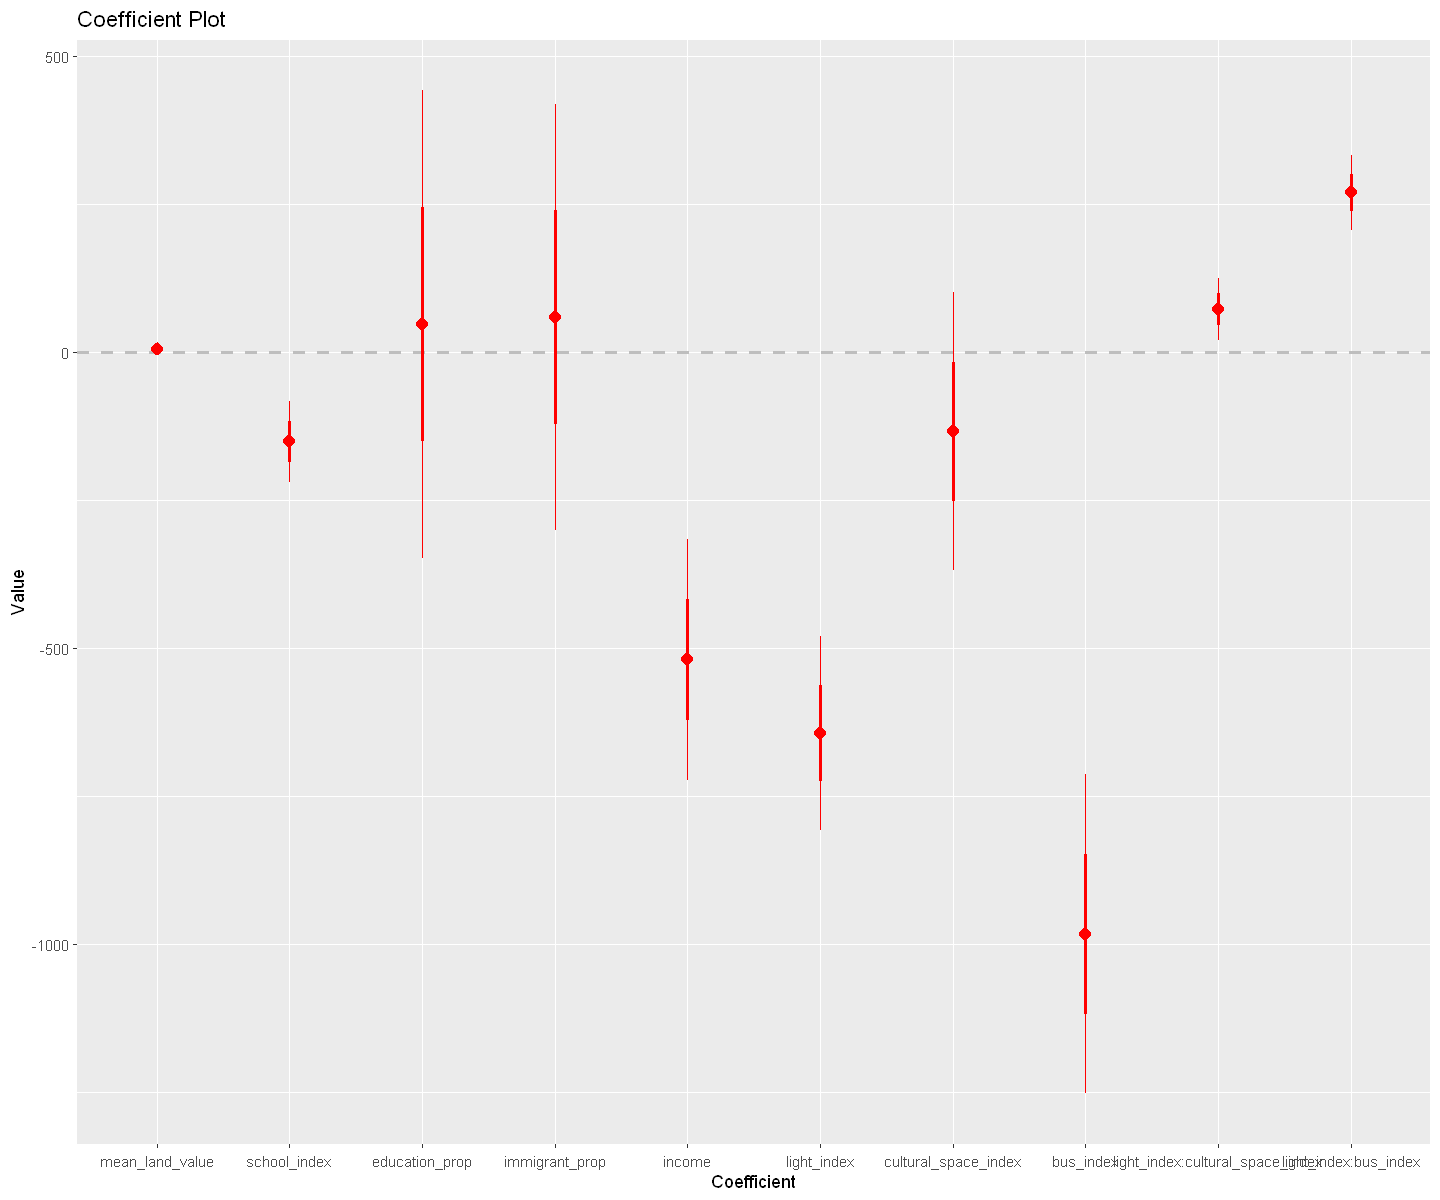

In [30]:
# Testing our specifications in final proposal, with robust standard error
reg_interaction <- lm(crime_rate ~ mean_land_value + school_index + education_prop + immigrant_prop + income + light_index
     + cultural_space_index + bus_index + light_index:cultural_space_index + light_index:bus_index, data = census_index_crime)
     
se_interaction <- sqrt(diag(vcovHC(reg_interaction, type = "HC1")))

stargazer(reg_interaction, se = list(se_interaction), type = "text", dep.var.labels = c("Crime Rate"))

coefplot(reg_interaction, intercept = FALSE, horizontal = TRUE, color = "red")

Although all explanatory variables have large p-values, the model generally has a larger F statistic comparing to previous model including all variables. However the F statistic is still lower than that excluded "insignificant" controls.


                             Dependent variable:    
                         ---------------------------
                                 Crime Rate         
----------------------------------------------------
mean_land_value                     4.383           
                                   (5.605)          
                                                    
school_index                     -132.289***        
                                  (37.982)          
                                                    
education_prop                     -51.766          
                                  (216.186)         
                                                    
immigrant_prop                     35.730           
                                  (205.031)         
                                                    
income                           -489.704***        
                                  (173.470)         
                                             

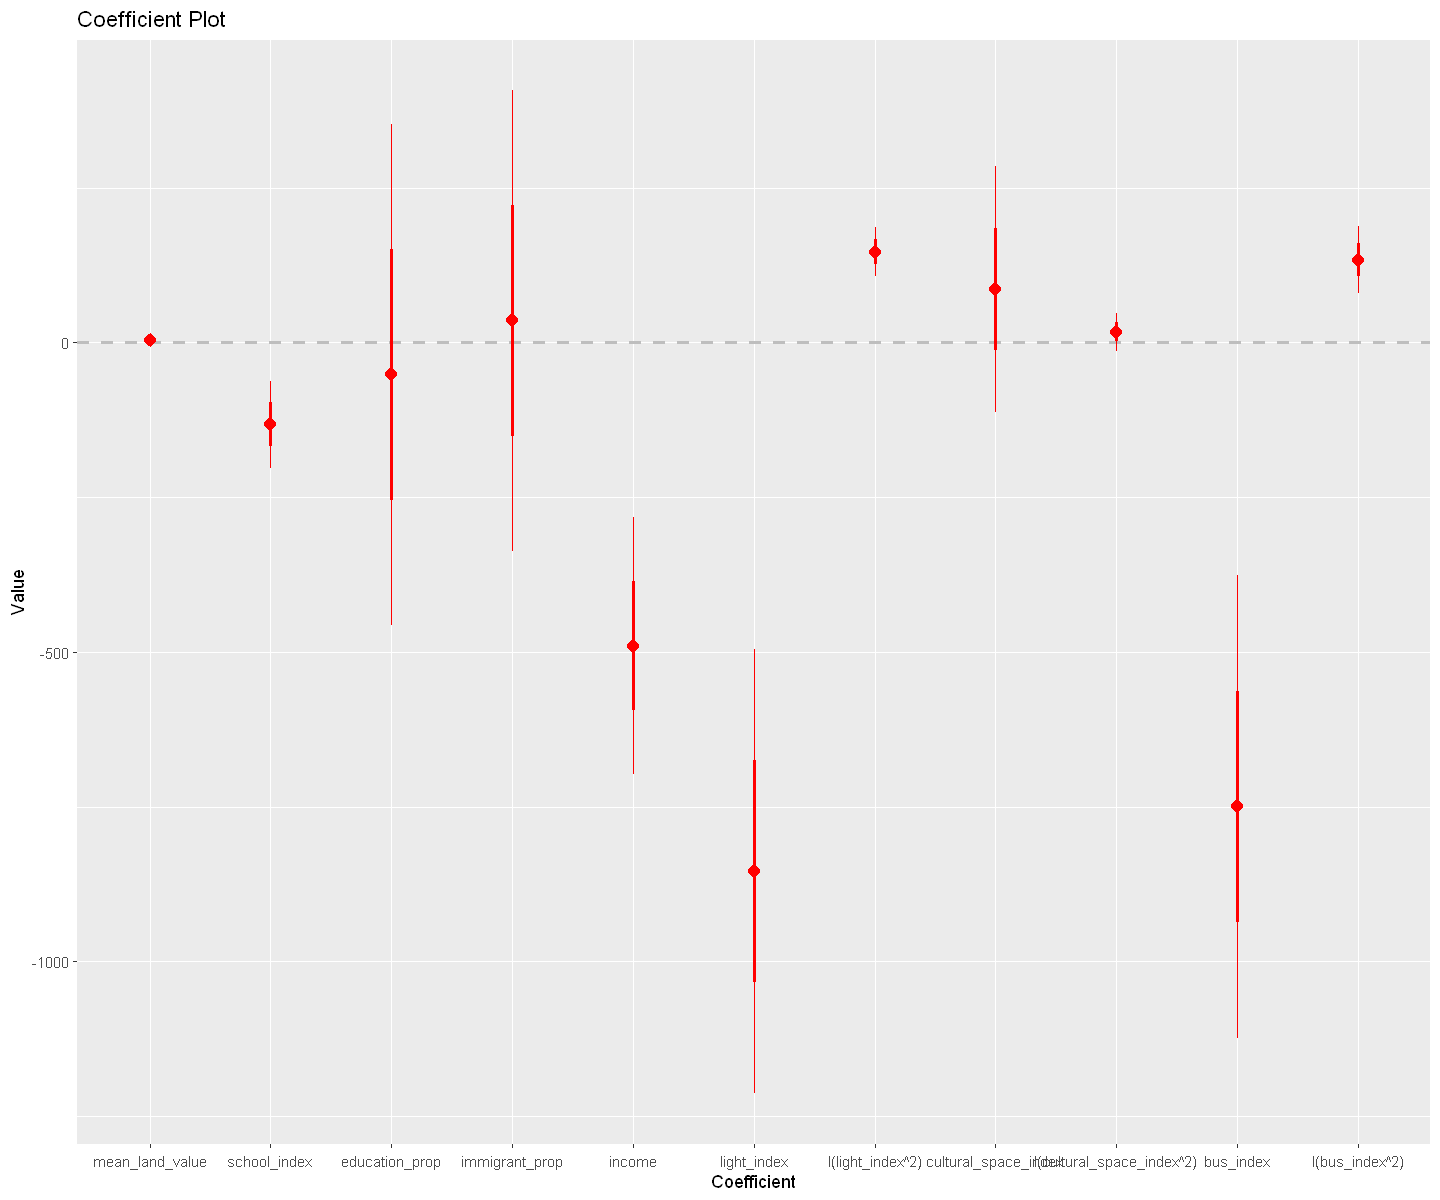

In [31]:
# Testing the specification with quadratic terms
reg_squared <- lm(crime_rate ~ mean_land_value + school_index  + education_prop + immigrant_prop + income + light_index + I(light_index^2)
     + cultural_space_index + I(cultural_space_index^2) + bus_index + I(bus_index^2), data = census_index_crime)
     
se_squared <- sqrt(diag(vcovHC(reg_squared, type = "HC1")))

stargazer(reg_squared, se =  list(se_interaction), type = "text", dep.var.labels = c("Crime Rate"))

coefplot(reg_squared, intercept = FALSE, horizontal = TRUE, color = "red")

We noticed a situation that is similar to the model with interaction happened.  

In [32]:
# Show four fitted models in a single output table
se_short <- sqrt(diag(vcovHC(reg1, type = "HC1")))

stargazer(reg1, reg_all, reg_interaction, reg_squared, se = list(se_short, se, se_interaction, se_squared), 
column.labels = c("short","all", "interaction", "squared"),  type = "text", dep.var.labels = c("Crime Rate"))


                                                                        Dependent variable:                                       
                                 -------------------------------------------------------------------------------------------------
                                                                            Crime Rate                                            
                                          short                    all                 interaction                squared         
                                           (1)                     (2)                     (3)                      (4)           
----------------------------------------------------------------------------------------------------------------------------------
mean_land_value                                                   7.986                   6.142                    4.383          
                                                                 (7.369)          

In [33]:
reg2 <- lm(crime_rate ~ log(mean_land_value), data = census_index_crime)
reg3 <- lm(crime_rate ~ mean_land_value + I(mean_land_value^2), data = census_index_crime)

se2 <- sqrt(diag(vcovHC(reg2, type = "HC1")))
se3 <- sqrt(diag(vcovHC(reg3, type = "HC1")))

stargazer(reg2, reg3, se = list(se2, se3), 
column.labels = c("log","squared"),  type = "text", dep.var.labels = c("Crime Rate"))


                                 Dependent variable:             
                     --------------------------------------------
                                      Crime Rate                 
                              log                  squared       
                              (1)                    (2)         
-----------------------------------------------------------------
log(mean_land_value)       112.032***                            
                            (33.057)                             
                                                                 
mean_land_value                                   50.625***      
                                                  (16.419)       
                                                                 
I(mean_land_value2)                               -0.904***      
                                                   (0.285)       
                                                                 
Constant 

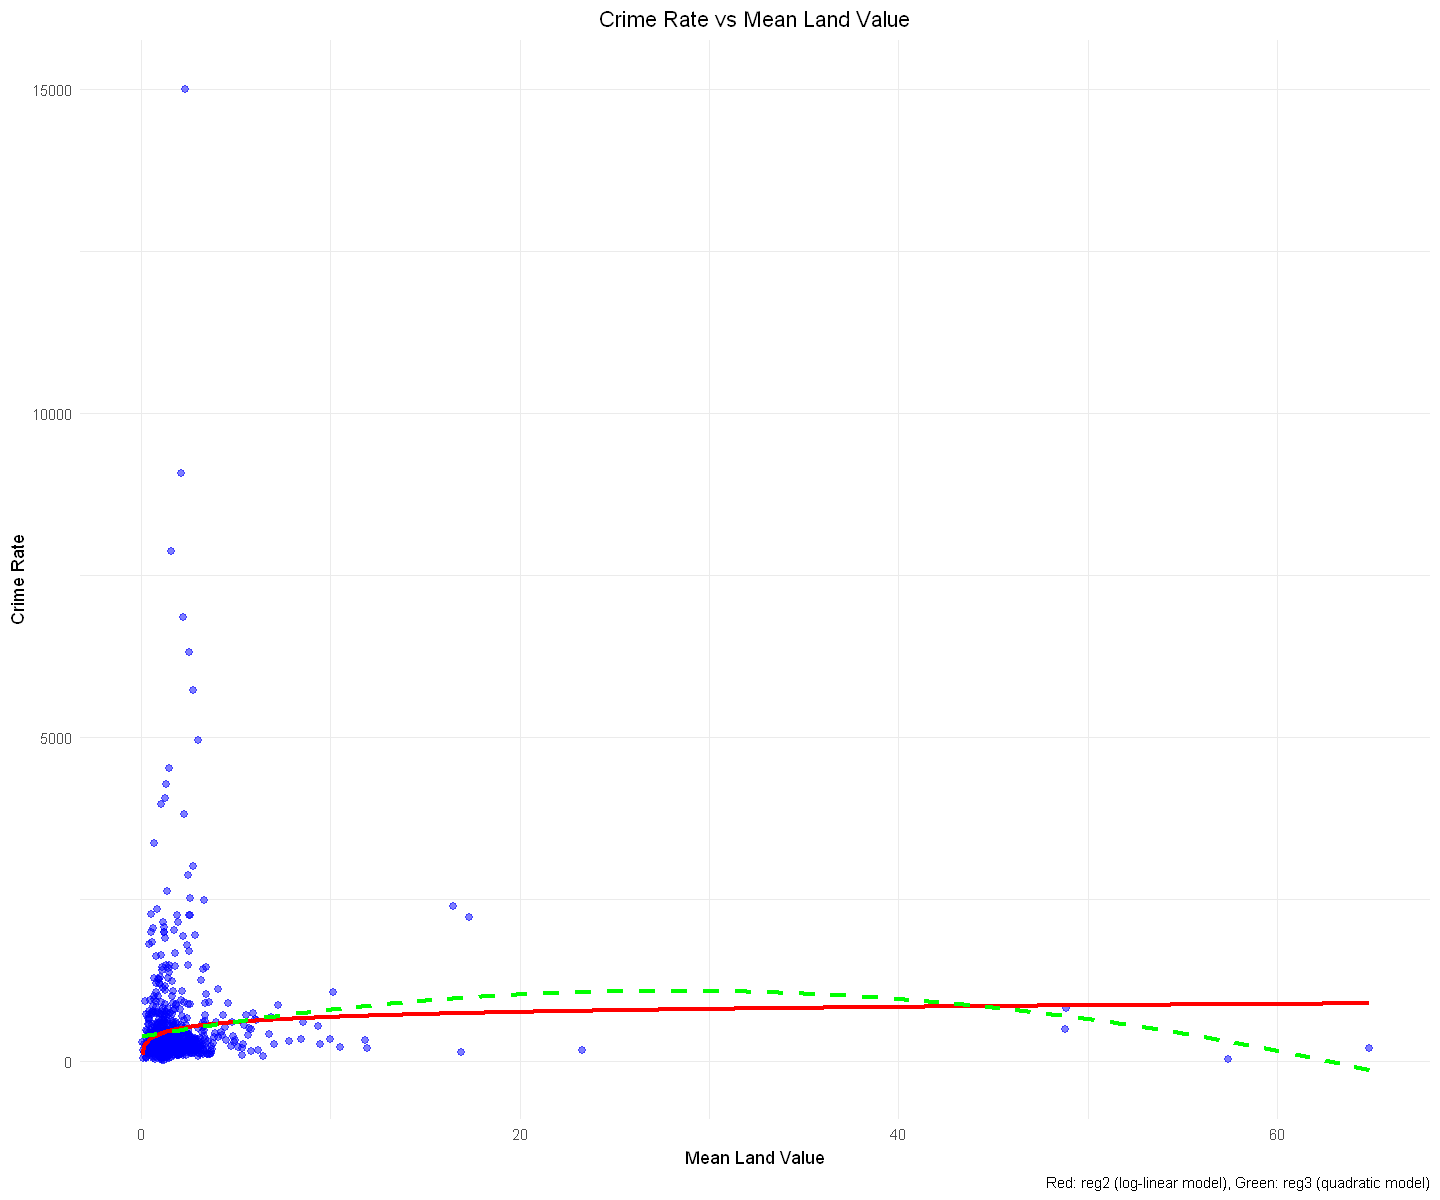

In [34]:
# Create a new data frame for predictions
census_index_crime$pred_reg2 <- predict(reg2)  # Predictions from reg2
census_index_crime$pred_reg3 <- predict(reg3)  # Predictions from reg3

# Generate a sequence of `mean_land_value` for smoother curves
land_value_seq <- seq(min(census_index_crime$mean_land_value), max(census_index_crime$mean_land_value), length.out = 500)

# Predictions for smoother visualization
smooth_data <- data.frame(
  mean_land_value = land_value_seq,
  pred_reg2 = predict(reg2, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg3 = predict(reg3, newdata = data.frame(mean_land_value = land_value_seq))
)

# Plot observed data and regression lines
ggplot(census_index_crime, aes(x = mean_land_value, y = crime_rate)) +
  geom_point(alpha = 0.5, color = "blue", size = 2) + # Data points
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg2), color = "red", size = 1.2) + # reg2 line
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg3), color = "green", size = 1.2, linetype = "dashed") + # reg3 line
  labs(
    title = "Crime Rate vs Mean Land Value",
    x = "Mean Land Value",
    y = "Crime Rate",
    caption = "Red: reg2 (log-linear model), Green: reg3 (quadratic model)"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))


Call:
lm(formula = log(crime_rate) ~ log(mean_land_value), data = census_index_crime)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0183 -0.4950 -0.0921  0.3787  3.8691 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           5.63816    0.02848 197.954  < 2e-16 ***
log(mean_land_value)  0.12702    0.03737   3.399 0.000704 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8122 on 987 degrees of freedom
Multiple R-squared:  0.01157,	Adjusted R-squared:  0.01057 
F-statistic: 11.55 on 1 and 987 DF,  p-value: 0.0007044


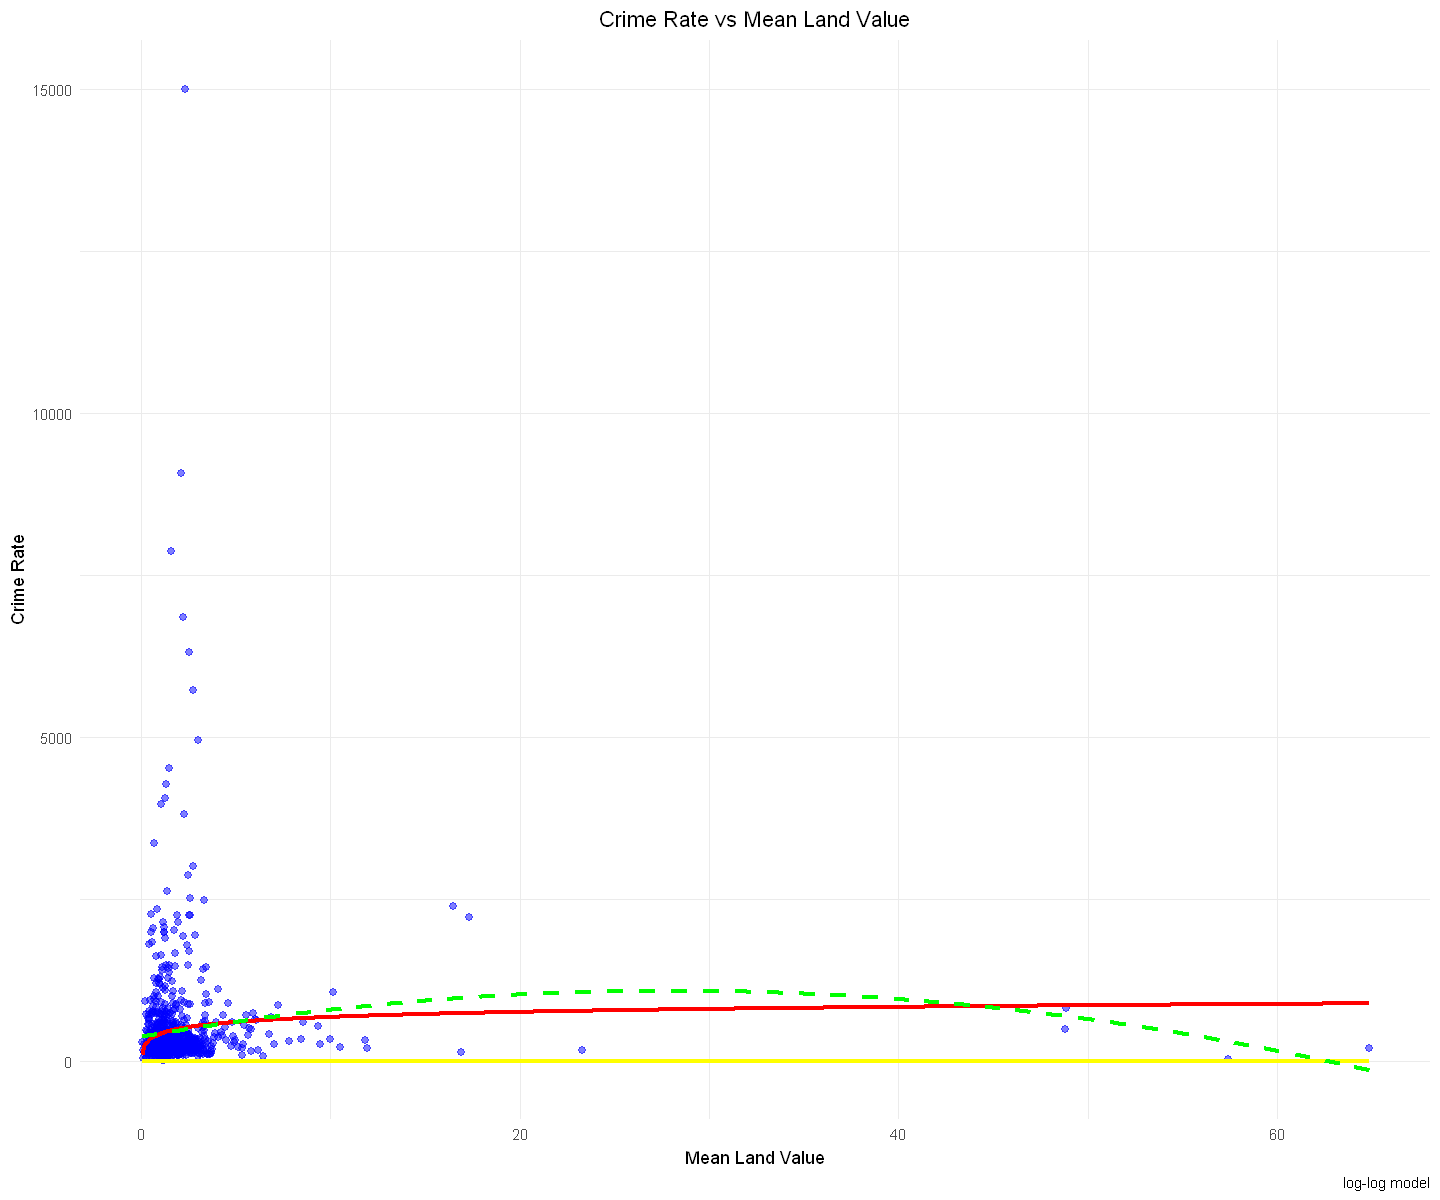

In [35]:
reg_log <- lm(log(crime_rate) ~ log(mean_land_value), data = census_index_crime)
census_index_crime$pred_reg4 <- predict(reg_log)

summary(reg_log)

# Predictions for smoother visualization
smooth_data <- data.frame(
  mean_land_value = land_value_seq,
    pred_reg2 = predict(reg2, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg3 = predict(reg3, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg4 = predict(reg_log, newdata = data.frame(mean_land_value = land_value_seq))
)

# Plot observed data and regression lines
ggplot(census_index_crime, aes(x = mean_land_value, y = crime_rate)) +
  geom_point(alpha = 0.5, color = "blue", size = 2) + # Data points
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg4), color = "yellow", size = 1.2) + # reg_log line
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg2), color = "red", size = 1.2) + # reg2 line
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg3), color = "green", size = 1.2, linetype = "dashed") + # reg3 line
  labs(
    title = "Crime Rate vs Mean Land Value",
    x = "Mean Land Value",
    y = "Crime Rate",
    caption = "log-log model"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))



Call:
lm(formula = log(crime_rate) ~ log(mean_land_value), data = census_index_crime)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0183 -0.4950 -0.0921  0.3787  3.8691 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           5.63816    0.02848 197.954  < 2e-16 ***
log(mean_land_value)  0.12702    0.03737   3.399 0.000704 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8122 on 987 degrees of freedom
Multiple R-squared:  0.01157,	Adjusted R-squared:  0.01057 
F-statistic: 11.55 on 1 and 987 DF,  p-value: 0.0007044



Call:
lm(formula = crime_rate ~ mean_land_value + I(mean_land_value^2), 
    data = census_index_crime)

Residuals:
    Min      1Q  Median      3Q     Max 
 -904.0  -275.5  -185.6   -30.7 14507.3 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          378.7202    40.8893   9.262  < 2e-16 ***
mean_land_value       50.6250    19.0437   2.658  0.00798 ** 
I(mean_land_value^2)  -0.9041     0.3601  -2.511  0.01219 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 839.8 on 986 degrees of freedom
Multiple R-squared:  0.007128,	Adjusted R-squared:  0.005114 
F-statistic: 3.539 on 2 and 986 DF,  p-value: 0.02941


Warning message in log(pred_reg3):
"NaNs produced"
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`)."


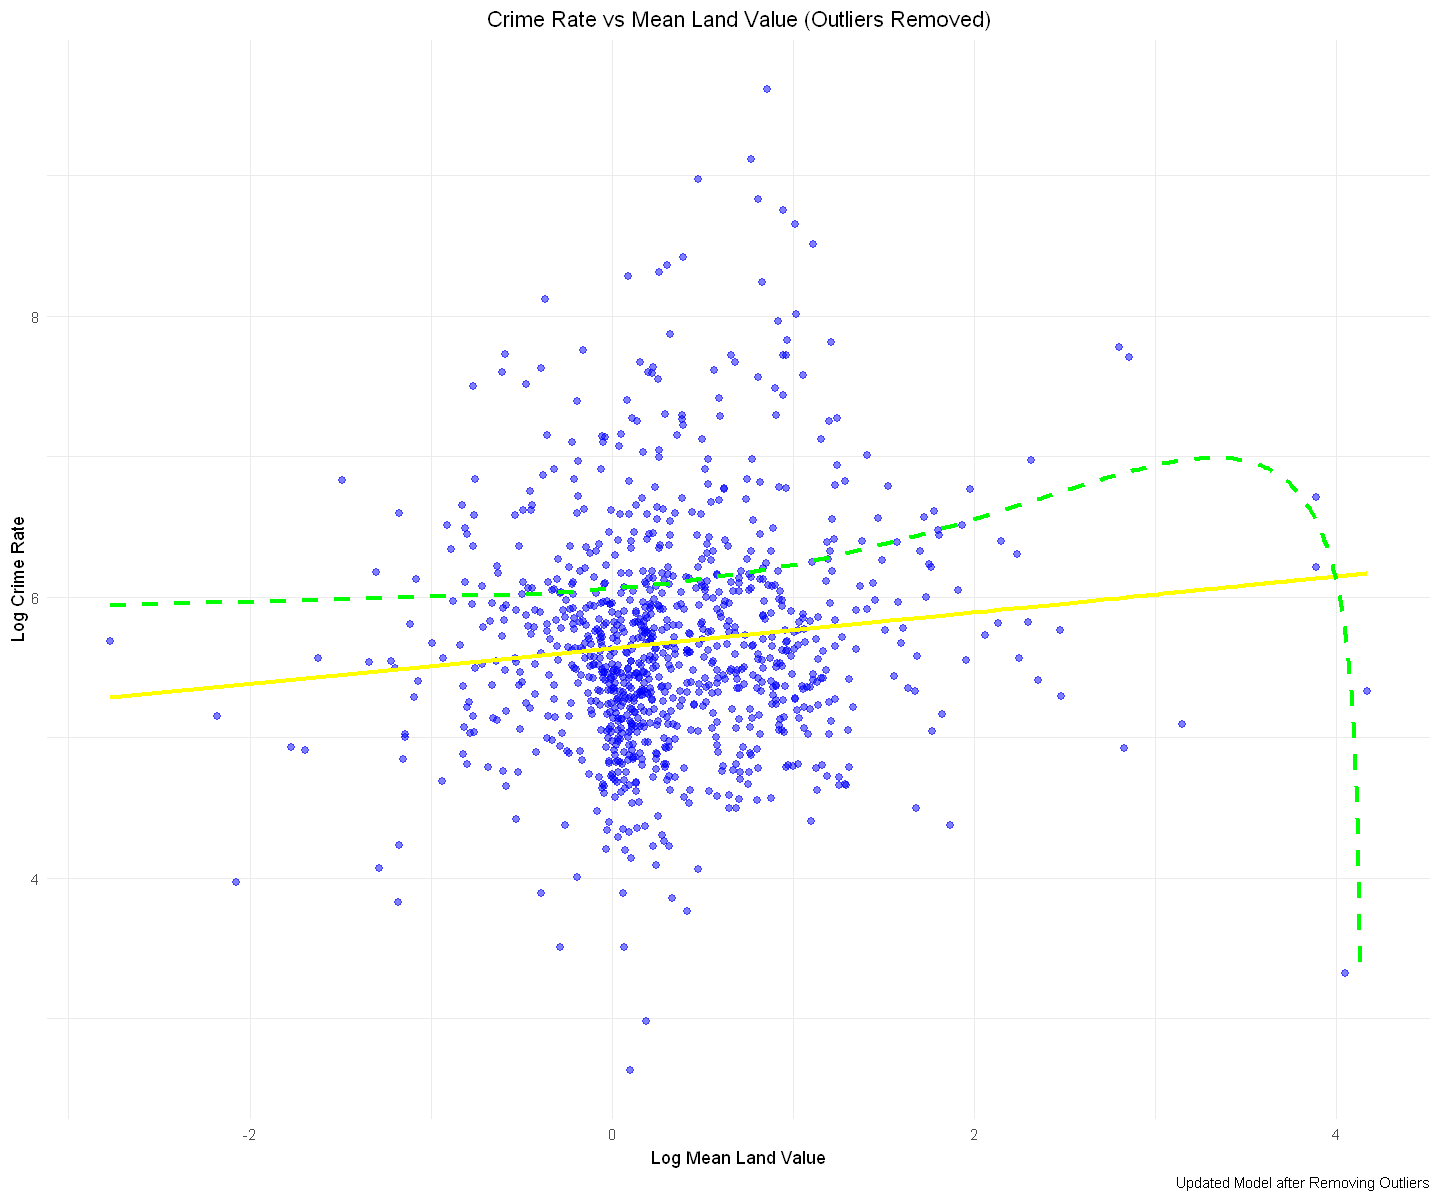

In [36]:
# census_index_crime <- census_index_crime %>%
#   arrange(desc(mean_land_value)) %>% 
#   slice(-1:-4)                     


reg_log <- lm(log(crime_rate) ~ log(mean_land_value), data = census_index_crime)
reg2 <- lm(crime_rate ~ log(mean_land_value), data = census_index_crime)
reg3 <- lm(crime_rate ~ mean_land_value + I(mean_land_value^2), data = census_index_crime)

census_index_crime$pred_reg4 <- predict(reg_log)

summary(reg_log)
summary(reg3)

land_value_seq <- seq(min(census_index_crime$mean_land_value), 
                      max(census_index_crime$mean_land_value), length.out = 100)

smooth_data <- data.frame(
  mean_land_value = land_value_seq,
  pred_reg2 = predict(reg2, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg3 = predict(reg3, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg4 = predict(reg_log, newdata = data.frame(mean_land_value = land_value_seq))
)

ggplot(census_index_crime, aes(x = log(mean_land_value), y = log(crime_rate))) +
  geom_point(alpha = 0.5, color = "blue", size = 2) + 
  geom_line(data = smooth_data, aes(x = log(mean_land_value), y = pred_reg4), color = "yellow", size = 1.2) + # reg_log line
  geom_line(data = smooth_data, aes(x = log(mean_land_value), y = log(pred_reg3)), color = "green", size = 1.2, linetype = "dashed") + # reg3 line
  labs(
    title = "Crime Rate vs Mean Land Value (Outliers Removed)",
    x = "Log Mean Land Value",
    y = "Log Crime Rate",
    caption = "Updated Model after Removing Outliers"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))


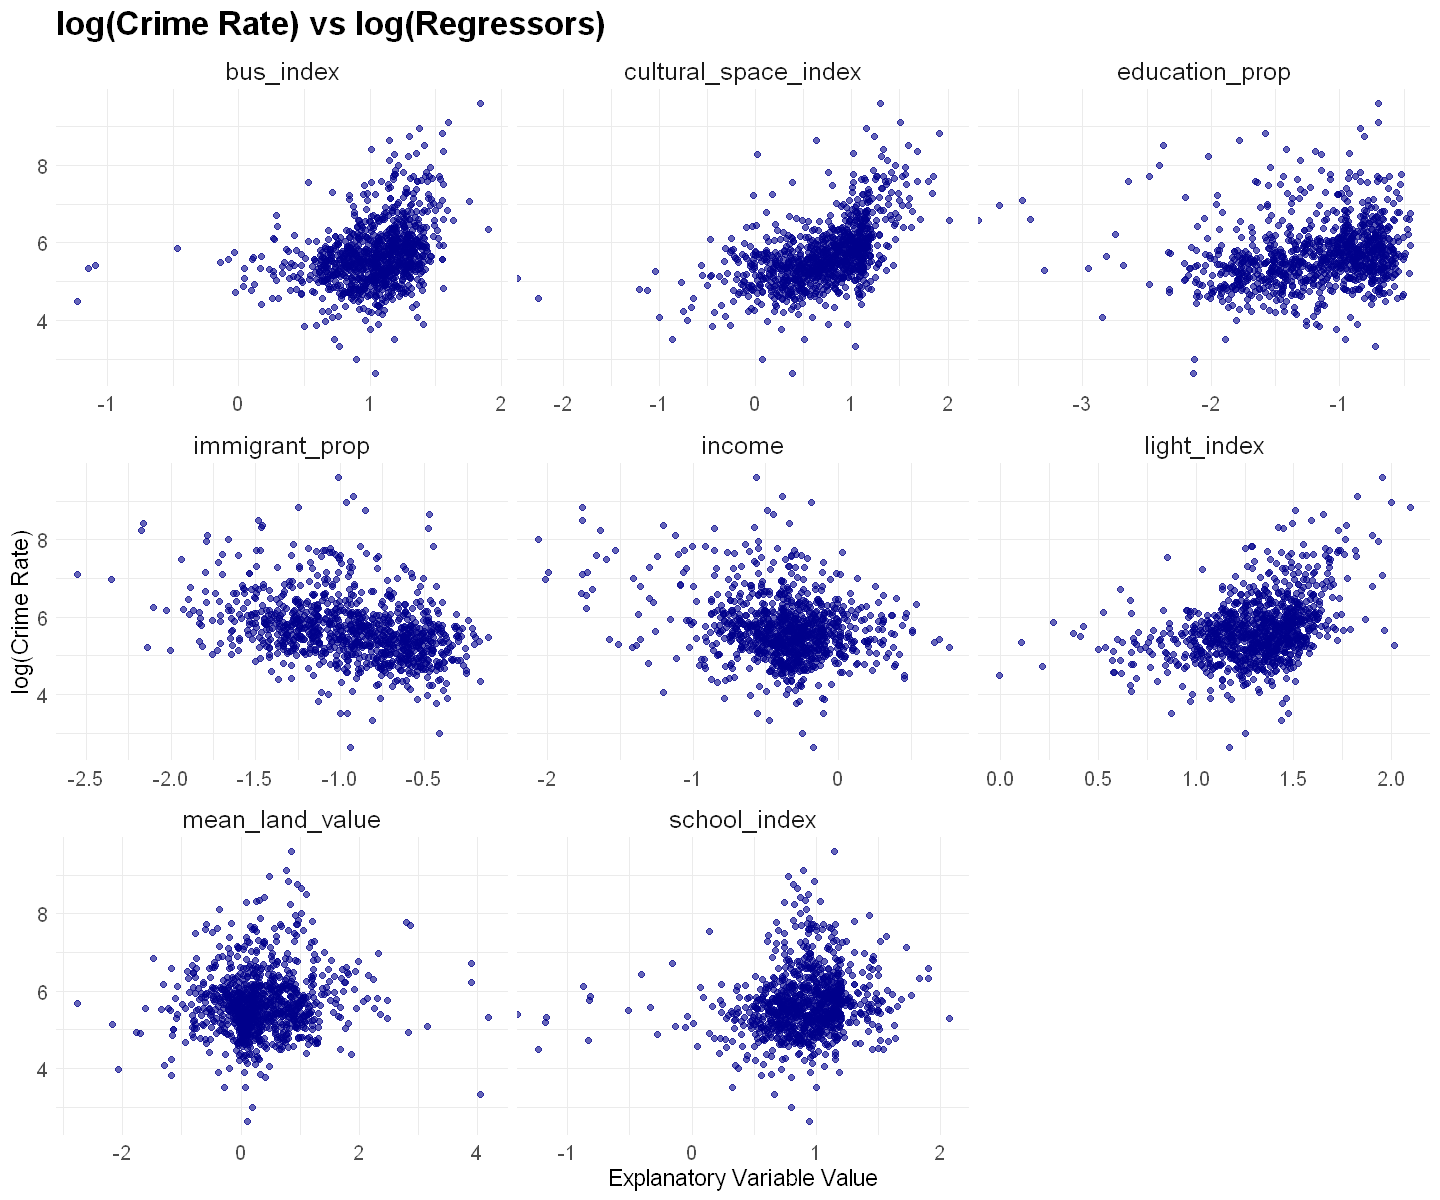

In [37]:
regressors <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')

long_data <- census_index_crime |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

log_log_variables_scatter <- ggplot(long_data, aes(x = log(value), y = log(crime_rate))) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "log(Crime Rate) vs log(Regressors)",
       x = "Explanatory Variable Value",
       y = "log(Crime Rate)") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

log_log_variables_scatter

In [38]:
# Identify variables with zeros
zero_counts <- sapply(census_index_crime, function(x) {
  if (is.numeric(x)) {
    sum(x == 0, na.rm = TRUE)
  } else {
    NA
  }
})
print("Variables with zero counts:")
print(zero_counts)

[1] "Variables with zero counts:"
                name           households            dwellings 
                  NA                    0                    0 
          population   population_density               region 
                   0                    0                   NA 
          area_sq_km                  age               income 
                   0                    0                    0 
      immigrant_prop       education_prop         school_index 
                   0                    1                    1 
         light_index            bus_index cultural_space_index 
                   0                    0                    1 
         crime_count           crime_rate      mean_land_value 
                   0                    0                    0 
            geometry            pred_reg2            pred_reg3 
                  NA                    0                    0 
           pred_reg4 
                   0 


In [39]:
min_positive_value_school <- min(census_index_crime$school_index[census_index_crime$school_index > 0], na.rm = TRUE)
min_positive_value_cultural_space <- min(census_index_crime$cultural_space_index[census_index_crime$cultural_space_index  > 0], na.rm = TRUE)

In [40]:
# Replace 0 with a small constant for log_cultural_space_index and remove log transformation for immigrant_prop and education_prop
census_index_crime_log <- census_index_crime %>% 
  mutate(
    log_crime_rate = log(crime_rate),
    log_mean_land_value = log(mean_land_value),
    log_school_index = log(ifelse(school_index == 0, min_positive_value_school/2, school_index)),
    log_light_index = log(light_index),
    log_bus_index = log(bus_index),
    log_cultural_space_index = log(ifelse(cultural_space_index == 0, min_positive_value_cultural_space/2, cultural_space_index)),
    log_income = log(income),
    immigrant_prop = immigrant_prop,  
    education_prop = education_prop 
  )

In [41]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
reg_log <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + log_bus_index
                + log_cultural_space_index + log_income + 
                immigrant_prop + education_prop, 
              data = census_index_crime_log)

# Display summary of the model
summary(reg_log)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log, ~ fitted(reg_log) + I(fitted(reg_log)^2), data = census_index_crime_log)
print(white_test)

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  reg_log_robust <- coeftest(reg_log, vcov = vcovHC(reg_log, type = "HC1"))
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust)
} else {
  print("No significant heteroskedasticity detected.")
}
  # Use regular standard errors
  robust_se <- coef(summary(reg_log))[, "Std. Error"]

# Generate a regression table with stargazer
stargazer(reg_log, type = "text", 
          title = "Log-Log Regression Results", 
          dep.var.labels = c("Log Crime Rate"))

if (exists("reg_log_robust")) {
  stargazer(reg_log, type = "text", 
            title = "Log-Log Regression Results with Robust Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se))
}


Call:
lm(formula = log_crime_rate ~ log_mean_land_value + log_school_index + 
    log_light_index + log_bus_index + log_cultural_space_index + 
    log_income + immigrant_prop + education_prop, data = census_index_crime_log)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5466 -0.3695 -0.0369  0.3490  2.6482 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.09645    0.17241  23.760  < 2e-16 ***
log_mean_land_value       0.16299    0.03015   5.406 8.09e-08 ***
log_school_index         -0.61528    0.09069  -6.785 2.01e-11 ***
log_light_index           1.29560    0.15704   8.250 5.07e-16 ***
log_bus_index             0.05070    0.12952   0.391 0.695546    
log_cultural_space_index  0.42647    0.07203   5.921 4.42e-09 ***
log_income               -0.42709    0.06655  -6.417 2.16e-10 ***
immigrant_prop           -0.81878    0.16651  -4.917 1.03e-06 ***
education_prop            0.70009    0.19232   3.640 0.000287 ***
---
S


	studentized Breusch-Pagan test

data:  reg_log
BP = 53.291, df = 2, p-value = 2.679e-12

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)               4.096452   0.198863 20.5994 < 2.2e-16 ***
log_mean_land_value       0.162993   0.041997  3.8810  0.000111 ***
log_school_index         -0.615279   0.104098 -5.9106 4.701e-09 ***
log_light_index           1.295596   0.197121  6.5726 8.023e-11 ***
log_bus_index             0.050700   0.133531  0.3797  0.704262    
log_cultural_space_index  0.426473   0.090629  4.7057 2.893e-06 ***
log_income               -0.427087   0.069252 -6.1671 1.016e-09 ***
immigrant_prop           -0.818782   0.173956 -4.7068 2.878e-06 ***
education_prop            0.700092   0.211434  3.3112  0.000963 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Log-Log Regression Results
                             Dependent var

In [42]:
vif(reg_log)|>
    tidy()

Warning message in tidy.numeric(vif(reg_log)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_mean_land_value,1.060750
log_school_index,2.466489
log_light_index,3.797726
log_bus_index,4.034026
log_cultural_space_index,2.962180
log_income,1.394975
immigrant_prop,1.523684
education_prop,1.637432


In [43]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
reg_log2 <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + 
                log_cultural_space_index + log_income + 
                immigrant_prop + education_prop, 
              data = census_index_crime_log)

# Display summary of the model
summary(reg_log2)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log2, ~ fitted(reg_log2) + I(fitted(reg_log2)^2), data = census_index_crime_log)
print(white_test)

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  reg_log_robust2 <- coeftest(reg_log2, vcov = vcovHC(reg_log2, type = "HC1"))
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust2)
  
  # Extract robust standard errors
  robust_se2 <- sqrt(diag(vcovHC(reg_log2, type = "HC1")))
} else {
  print("No significant heteroskedasticity detected.")
  
  # Use regular standard errors
  robust_se2 <- coef(summary(reg_log2))[, "Std. Error"]
}

# Generate a regression table with stargazer
stargazer(reg_log2, type = "text", 
          title = "Log-Log Regression Results", 
          dep.var.labels = c("Log Crime Rate"),
          ci=FALSE, 
          single.row=TRUE)

# Add robust standard errors if heteroskedasticity was detected
if (white_test$p.value < 0.05) {
  stargazer(reg_log2, type = "text", 
            title = "Log-Log Regression Results with Robust Standard Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se2),
            ci=FALSE, 
            single.row=TRUE)
}


Call:
lm(formula = log_crime_rate ~ log_mean_land_value + log_school_index + 
    log_light_index + log_cultural_space_index + log_income + 
    immigrant_prop + education_prop, data = census_index_crime_log)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5566 -0.3735 -0.0433  0.3480  2.6446 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.08839    0.17110  23.895  < 2e-16 ***
log_mean_land_value       0.16129    0.02982   5.409 7.98e-08 ***
log_school_index         -0.60200    0.08407  -7.161 1.57e-12 ***
log_light_index           1.32898    0.13180  10.083  < 2e-16 ***
log_cultural_space_index  0.42969    0.07152   6.008 2.65e-09 ***
log_income               -0.43241    0.06512  -6.640 5.20e-11 ***
immigrant_prop           -0.81785    0.16642  -4.914 1.04e-06 ***
education_prop            0.70149    0.19221   3.650 0.000276 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard e


	studentized Breusch-Pagan test

data:  reg_log2
BP = 52.882, df = 2, p-value = 3.288e-12

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)               4.088391   0.198262 20.6212 < 2.2e-16 ***
log_mean_land_value       0.161285   0.042207  3.8213 0.0001411 ***
log_school_index         -0.601999   0.098839 -6.0907 1.612e-09 ***
log_light_index           1.328985   0.175354  7.5789 8.056e-14 ***
log_cultural_space_index  0.429692   0.089823  4.7838 1.984e-06 ***
log_income               -0.432406   0.069310 -6.2387 6.552e-10 ***
immigrant_prop           -0.817848   0.173883 -4.7034 2.925e-06 ***
education_prop            0.701492   0.211415  3.3181 0.0009397 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Log-Log Regression Results
                             Dependent variable:    
                         ---------------------------
   

In [44]:
stargazer(reg_log, reg_log2, type = "text", 
        title = "Log-Log Regression Results with Robust Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se,robust_se2))


Log-Log Regression Results with Robust Errors
                                       Dependent variable:              
                         -----------------------------------------------
                                         Log Crime Rate                 
                                   (1)                     (2)          
------------------------------------------------------------------------
log_mean_land_value             0.163***                0.161***        
                                 (0.030)                 (0.042)        
                                                                        
log_school_index                -0.615***               -0.602***       
                                 (0.091)                 (0.099)        
                                                                        
log_light_index                 1.296***                1.329***        
                                 (0.157)                 (0.175)        
    

In [45]:
 stargazer(reg_log2, type = "text", 
            title = "Log-Log Regression Results with Robust Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se2))


Log-Log Regression Results with Robust Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_mean_land_value               0.161***          
                                   (0.042)          
                                                    
log_school_index                  -0.602***         
                                   (0.099)          
                                                    
log_light_index                   1.329***          
                                   (0.175)          
                                                    
log_cultural_space_index          0.430***          
                                   (0.090)          
                                                    
log_income                        -0.432***         
                                   (0.069)          

In [46]:
vif(reg_log2)|>
    tidy()

Warning message in tidy.numeric(vif(reg_log2)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_mean_land_value,1.038545
log_school_index,2.121349
log_light_index,2.677442
log_cultural_space_index,2.923575
log_income,1.336820
immigrant_prop,1.523370
education_prop,1.636866


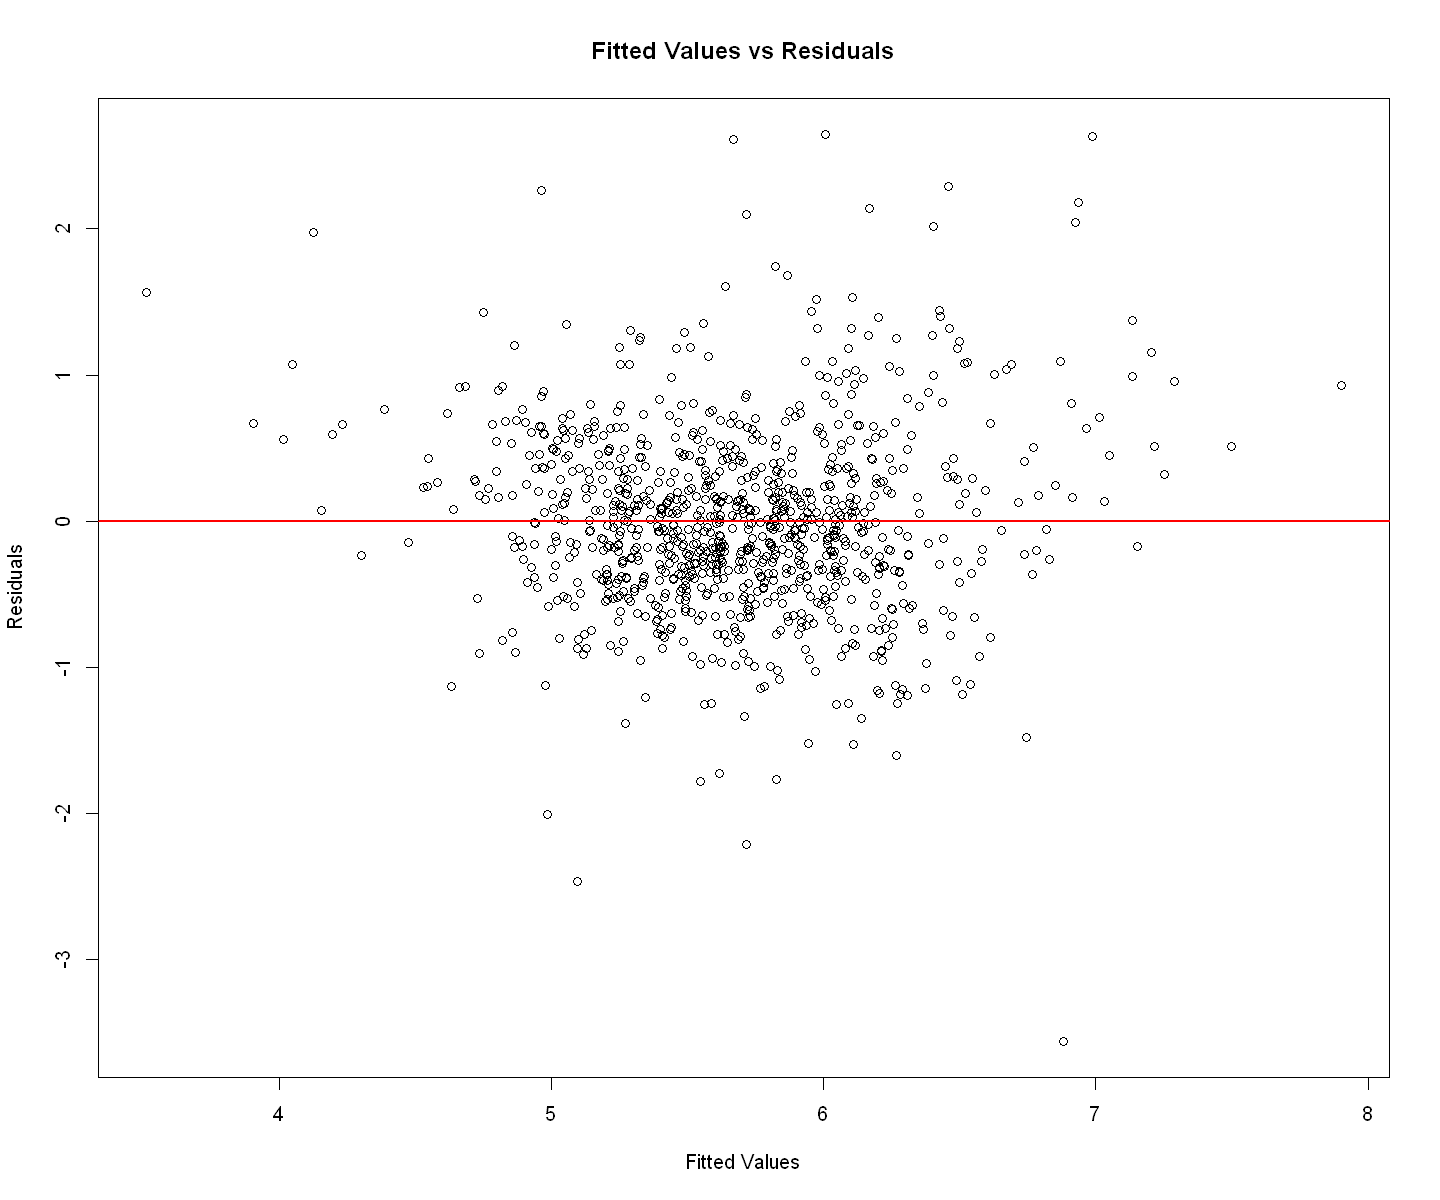

In [47]:
# Plot fitted values vs residuals
plot(fitted(reg_log2), residuals(reg_log2), 
     xlab = "Fitted Values", ylab = "Residuals",
     main = "Fitted Values vs Residuals")

# Add a horizontal line at 0 to assess heteroskedasticity
abline(h = 0, col = "red", lwd = 2)


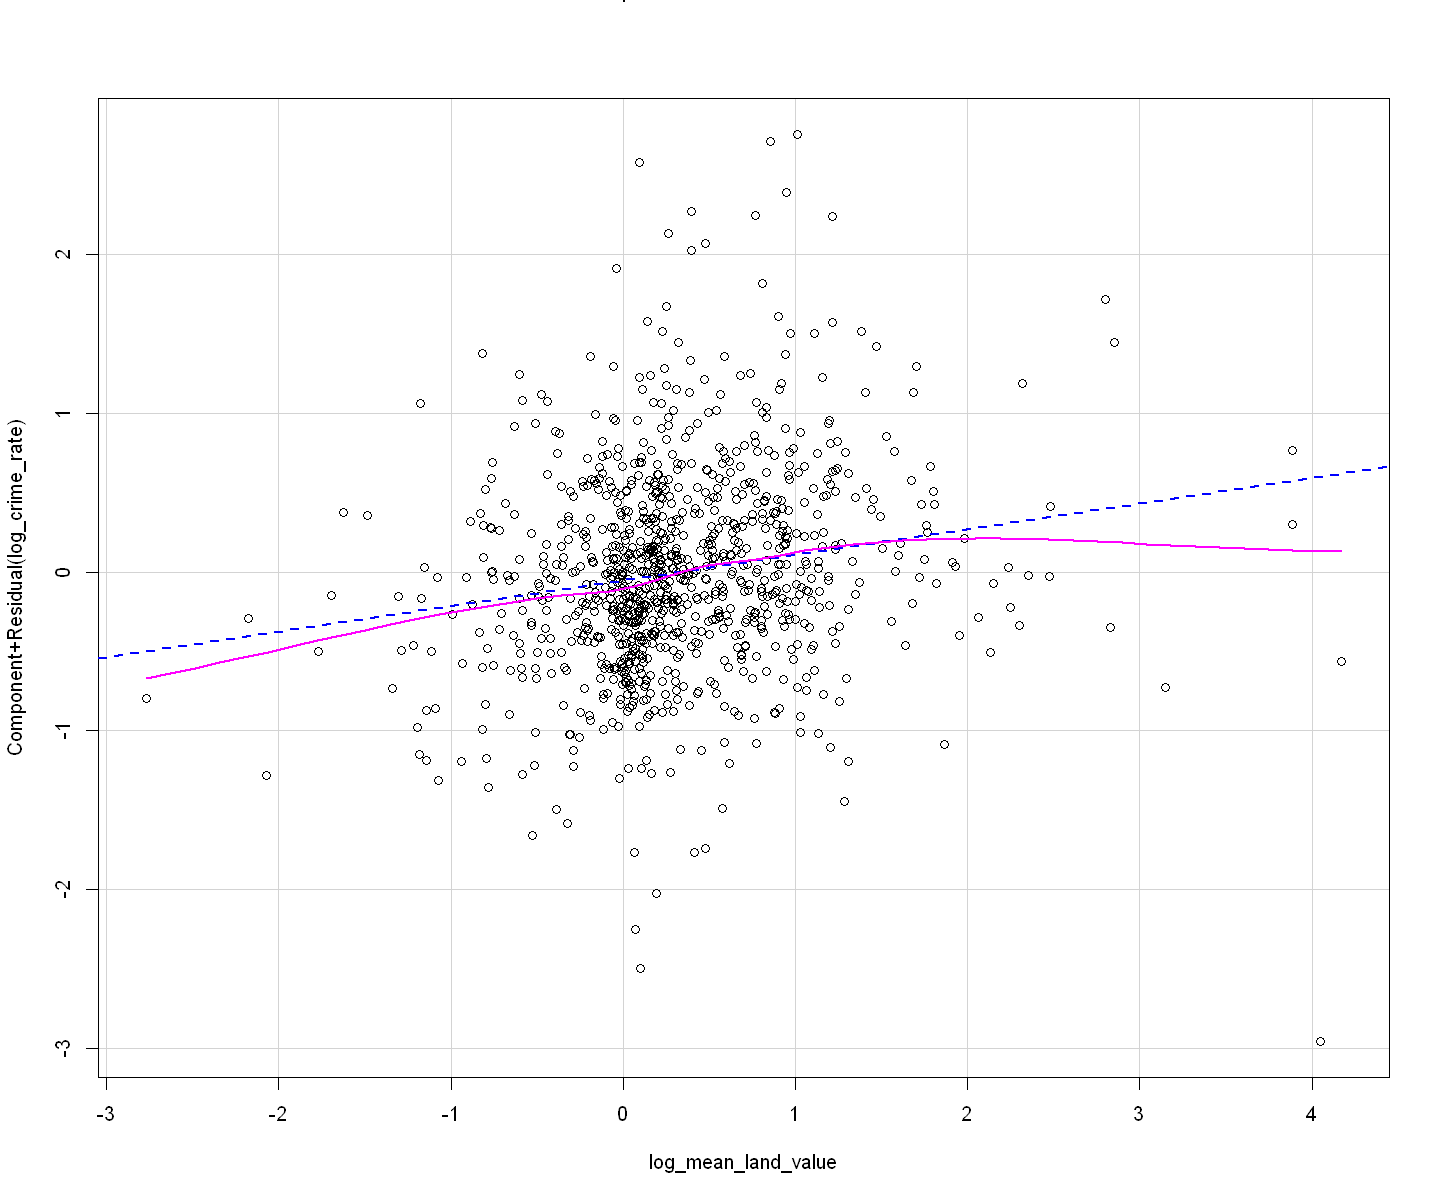

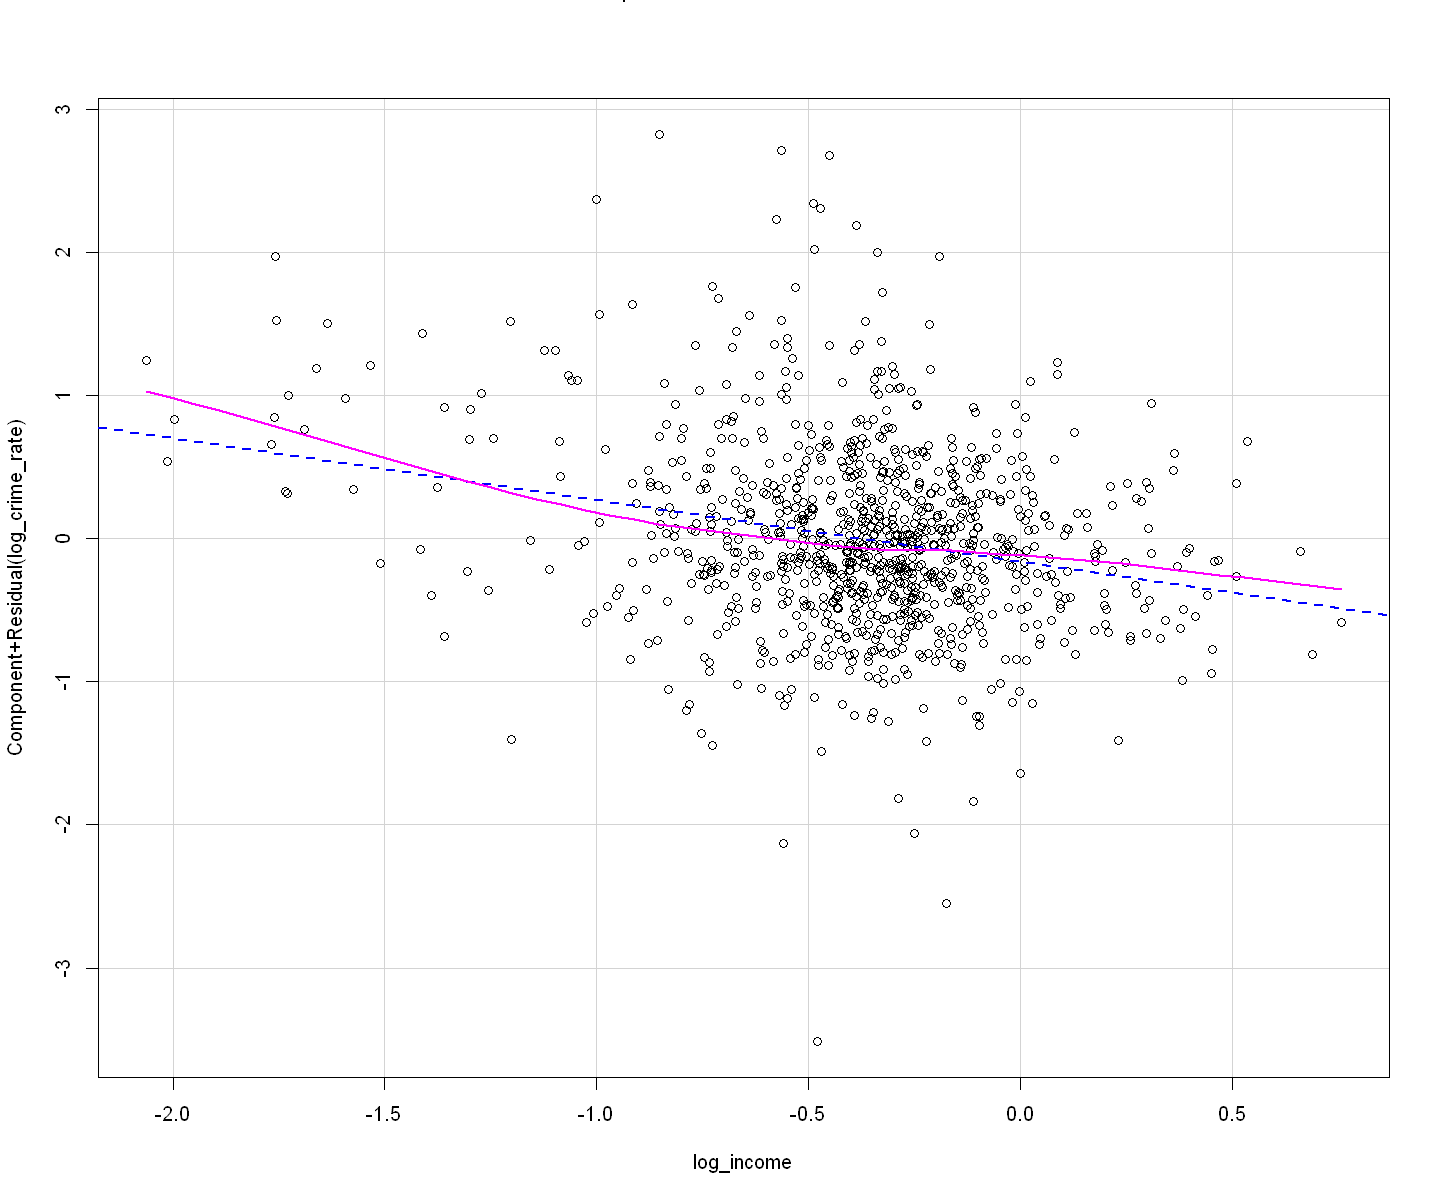

In [48]:
# Partial regression plot for log_mean_land_value
crPlots(reg_log2, terms = ~ log_mean_land_value)

# Partial regression plot for log_income
crPlots(reg_log2, terms = ~ log_income)

In [49]:
library(VancouvR)

Warning message:
"package 'VancouvR' was built under R version 4.4.2"


In [50]:
local_area_boundary <- get_cov_data("local-area-boundary")|>
    st_sf()

glimpse(local_area_boundary)

Rows: 22
Columns: 4
$ name         <chr> "Downtown", "Hastings-Sunrise", "Kerrisdale", "Marpole", …
$ geom         <chr> "{\"coordinates\": [[[-123.11226654052733, 49.29016494657…
$ geo_point_2d <chr> "49.28074707013743, -123.11656700827415", "49.27793405209…
$ geometry     <POLYGON [°]> POLYGON ((-123.1123 49.2901..., POLYGON ((-123.05…


In [51]:
census_index_crime_log_st <- st_sf(census_index_crime_log)
# Step 1: Fix invalid geometries using st_make_valid()
census_index_crime_log_st_valid <- st_make_valid(census_index_crime_log_st)
local_area_boundary_valid <- st_make_valid(local_area_boundary)

# Step 2: Filter local_area_boundary to include only "West End" and "Downtown"
selected_areas <- local_area_boundary_valid %>%
  filter(name %in% c("West End", "Downtown"))

# Optional: Simplify geometries if needed (helps in performance and resolves minor geometry issues)
# Adjust dTolerance as appropriate for your spatial resolution
census_index_crime_log_st_valid <- st_simplify(census_index_crime_log_st_valid, dTolerance = 0.01)
selected_areas <- st_simplify(selected_areas, dTolerance = 0.01)

# Step 3: Ensure both datasets use the same Coordinate Reference System (CRS)
desired_crs <- st_crs(selected_areas)
census_index_crime_log_st_valid <- st_transform(census_index_crime_log_st_valid, crs = desired_crs)

# Step 4: Perform spatial join to keep only records within "West End" and "Downtown"
census_index_crime_log_filtered <- st_join(
  census_index_crime_log_st_valid,
  selected_areas,
  join = st_within,
  left = FALSE
)

# Step 5: Verify the resulting dataset
glimpse(census_index_crime_log_filtered)

problematic_geometries <- census_index_crime_log_st[!st_is_valid(census_index_crime_log_st), ]
if(nrow(problematic_geometries) > 0){
  print("Problematic Geometries:")
  print(problematic_geometries)
} else {
  print("No problematic geometries found.")
}

Rows: 96
Columns: 32
$ name.x                   <chr> "59150777", "59150779", "59150780", "59150782…
$ households               <int> 622, 589, 1461, 301, 400, 1325, 320, 205, 404…
$ dwellings                <int> 658, 652, 1596, 338, 442, 1431, 366, 236, 440…
$ population               <int> 1212, 987, 2306, 464, 642, 1895, 566, 488, 70…
$ population_density       <dbl> 77692.3, 59101.8, 34728.9, 28466.3, 37764.7, …
$ region                   <chr> "Vancouver", "Vancouver", "Vancouver", "Vanco…
$ area_sq_km               <dbl> 0.01556, 0.01673, 0.06649, 0.01626, 0.01699, …
$ age                      <int> 1210, 990, 2305, 465, 640, 1895, 570, 490, 70…
$ income                   <dbl> 0.74496, 0.80512, 0.67533, 0.67456, 0.33792, …
$ immigrant_prop           <dbl> 0.3589109, 0.3140831, 0.3057242, 0.4418103, 0…
$ education_prop           <dbl> 0.4702970, 0.5116515, 0.4856895, 0.4849138, 0…
$ school_index             <dbl> 2.719488, 2.668375, 2.592803, 2.501097, 2.581…
$ light_index      

In [52]:
distinct(census_index_crime_log_filtered,name.y)

name.y
<chr>
Downtown
West End


In [53]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
reg_log_dt <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + 
                log_cultural_space_index + log_income + 
                immigrant_prop + education_prop, 
                data = census_index_crime_log_filtered)

# Display summary of the model
summary(reg_log_dt)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log_dt, ~ fitted(reg_log_dt) + I(fitted(reg_log_dt)^2), data = census_index_crime_log_filtered)
print(white_test)

# Initialize variable to store standard errors
robust_se_dt <- NULL

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  # Calculate robust variance-covariance matrix
  vcov_robust <- vcovHC(reg_log_dt, type = "HC1")
  
  # Extract variances from the diagonal
  variances <- diag(vcov_robust)
  
  # Check for negative variances
  if(any(variances < 0)){
    stop("Negative variances detected in the robust variance-covariance matrix. Please check the model specification.")
  }
  
  # Calculate robust standard errors
  robust_se_dt <- sqrt(variances)
  
  # Optionally, display the robust coefficients
  reg_log_robust_dt <- coeftest(reg_log_dt, vcov = vcov_robust)
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust_dt)
} else {
  print("No significant heteroskedasticity detected.")
  # Use regular standard errors
  robust_se_dt <- coef(summary(reg_log_dt))[, "Std. Error"]
}

# Generate a regression table with stargazer
if (!is.null(robust_se_dt)) {
  stargazer(reg_log_dt, type = "text", 
            title = "Log-Log Regression Results", 
            dep.var.labels = c("Log Crime Rate"),
            se = list(robust_se_dt),
            ci = FALSE, 
            single.row = TRUE)
} else {
  # If robust_se_dt is NULL, display the standard model without robust SEs
  stargazer(reg_log_dt, type = "text", 
            title = "Log-Log Regression Results", 
            dep.var.labels = c("Log Crime Rate"),
            ci = FALSE, 
            single.row = TRUE)
}


Call:
lm(formula = log_crime_rate ~ log_mean_land_value + log_school_index + 
    log_light_index + log_cultural_space_index + log_income + 
    immigrant_prop + education_prop, data = census_index_crime_log_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2552 -0.4457  0.0283  0.4705  1.7556 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)   
(Intercept)               3.13138    1.00777   3.107  0.00254 **
log_mean_land_value       0.09021    0.08120   1.111  0.26962   
log_school_index         -1.24309    0.70770  -1.757  0.08248 . 
log_light_index           1.71592    0.53758   3.192  0.00196 **
log_cultural_space_index  1.77631    0.64475   2.755  0.00713 **
log_income               -0.49660    0.35864  -1.385  0.16965   
immigrant_prop            0.45726    0.99197   0.461  0.64596   
education_prop           -1.72893    1.17988  -1.465  0.14639   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard e


	studentized Breusch-Pagan test

data:  reg_log_dt
BP = 6.9696, df = 2, p-value = 0.03066

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                          Estimate Std. Error t value Pr(>|t|)   
(Intercept)               3.131385   1.066312  2.9366 0.004234 **
log_mean_land_value       0.090211   0.151997  0.5935 0.554364   
log_school_index         -1.243093   0.773080 -1.6080 0.111423   
log_light_index           1.715920   0.785660  2.1840 0.031618 * 
log_cultural_space_index  1.776306   0.755169  2.3522 0.020894 * 
log_income               -0.496598   0.336364 -1.4764 0.143413   
immigrant_prop            0.457257   0.983415  0.4650 0.643103   
education_prop           -1.728928   1.181257 -1.4636 0.146857   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Log-Log Regression Results
                             Dependent variable:    
                         ---------------------------
                     

In [54]:
vif(reg_log_dt)|>
    tidy()

Warning message in tidy.numeric(vif(reg_log_dt)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_mean_land_value,1.227725
log_school_index,1.853210
log_light_index,2.373472
log_cultural_space_index,1.929406
log_income,2.140052
immigrant_prop,1.441339
education_prop,1.787394


In [55]:
stargazer(reg_log2, reg_log_dt, type = "text", 
        title = "Log-Log Regression Results with Robust Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se2,robust_se_dt),
        column.labels = c("Vancouver", "Downtown only"),
        single.row = TRUE)


Log-Log Regression Results with Robust Errors
                                      Dependent variable:             
                         ---------------------------------------------
                                        Log Crime Rate                
                                Vancouver            Downtown only    
                                   (1)                    (2)         
----------------------------------------------------------------------
log_mean_land_value         0.161*** (0.042)         0.090 (0.152)    
log_school_index            -0.602*** (0.099)       -1.243 (0.773)    
log_light_index             1.329*** (0.175)        1.716** (0.786)   
log_cultural_space_index    0.430*** (0.090)        1.776** (0.755)   
log_income                  -0.432*** (0.069)       -0.497 (0.336)    
immigrant_prop              -0.818*** (0.174)        0.457 (0.983)    
education_prop              0.701*** (0.211)        -1.729 (1.181)    
Constant                    4.

We notice that in Downtown, there are some very different behaviours of our variables. So we want to see if the existence of Insite in the region will have significant impact on the crime rate.

In [56]:
# Add insite dummy
locations_df <- data.frame(
  id = 1:3,
  lon = c(-123.10129, -123.10555, -123.12074), 
  lat = c(49.28160, 49.28302, 49.27544)          
) # Source: Google Map

locations_sf <- st_as_sf(locations_df, coords = c("lon", "lat"), crs = 4326)

if (st_crs(census_index_crime_log_st) != st_crs(locations_sf)) {
  locations_sf <- st_transform(locations_sf, st_crs(census_index_crime_log_st))
}

valid_geometries <- st_is_valid(census_index_crime_log_st)

if (!all(valid_geometries)) {
  invalid_indices <- which(!valid_geometries)
  invalid_reasons <- st_is_valid(census_index_crime_log_st[invalid_indices, ], reason = TRUE)
  cat("Invalid geometries found. Reasons:\n")
  print(invalid_reasons)

  census_index_crime_log_st <- st_make_valid(census_index_crime_log_st)

  valid_geometries <- st_is_valid(census_index_crime_log_st)
  
  if (!all(valid_geometries)) {
    census_index_crime_log_st <- st_buffer(census_index_crime_log_st, dist = 0)
    valid_geometries <- st_is_valid(census_index_crime_log_st)
    
    if (!all(valid_geometries)) {
      stop("Some geometries are still invalid after attempting to fix them.")
    }
  }
}

contains_result <- st_contains(census_index_crime_log_st, locations_sf, sparse = FALSE)

census_index_crime_log_st$insite_dummy <- as.integer(apply(contains_result, 1, any))

head(census_index_crime_log_st$insite_dummy)

Invalid geometries found. Reasons:
[1] "Loop 0: Edge 8 is degenerate (duplicate vertex)"  
[2] "Loop 0: Edge 149 is degenerate (duplicate vertex)"


[1] 0 0 0 0 0 0

`geom_smooth()` using formula = 'y ~ x'


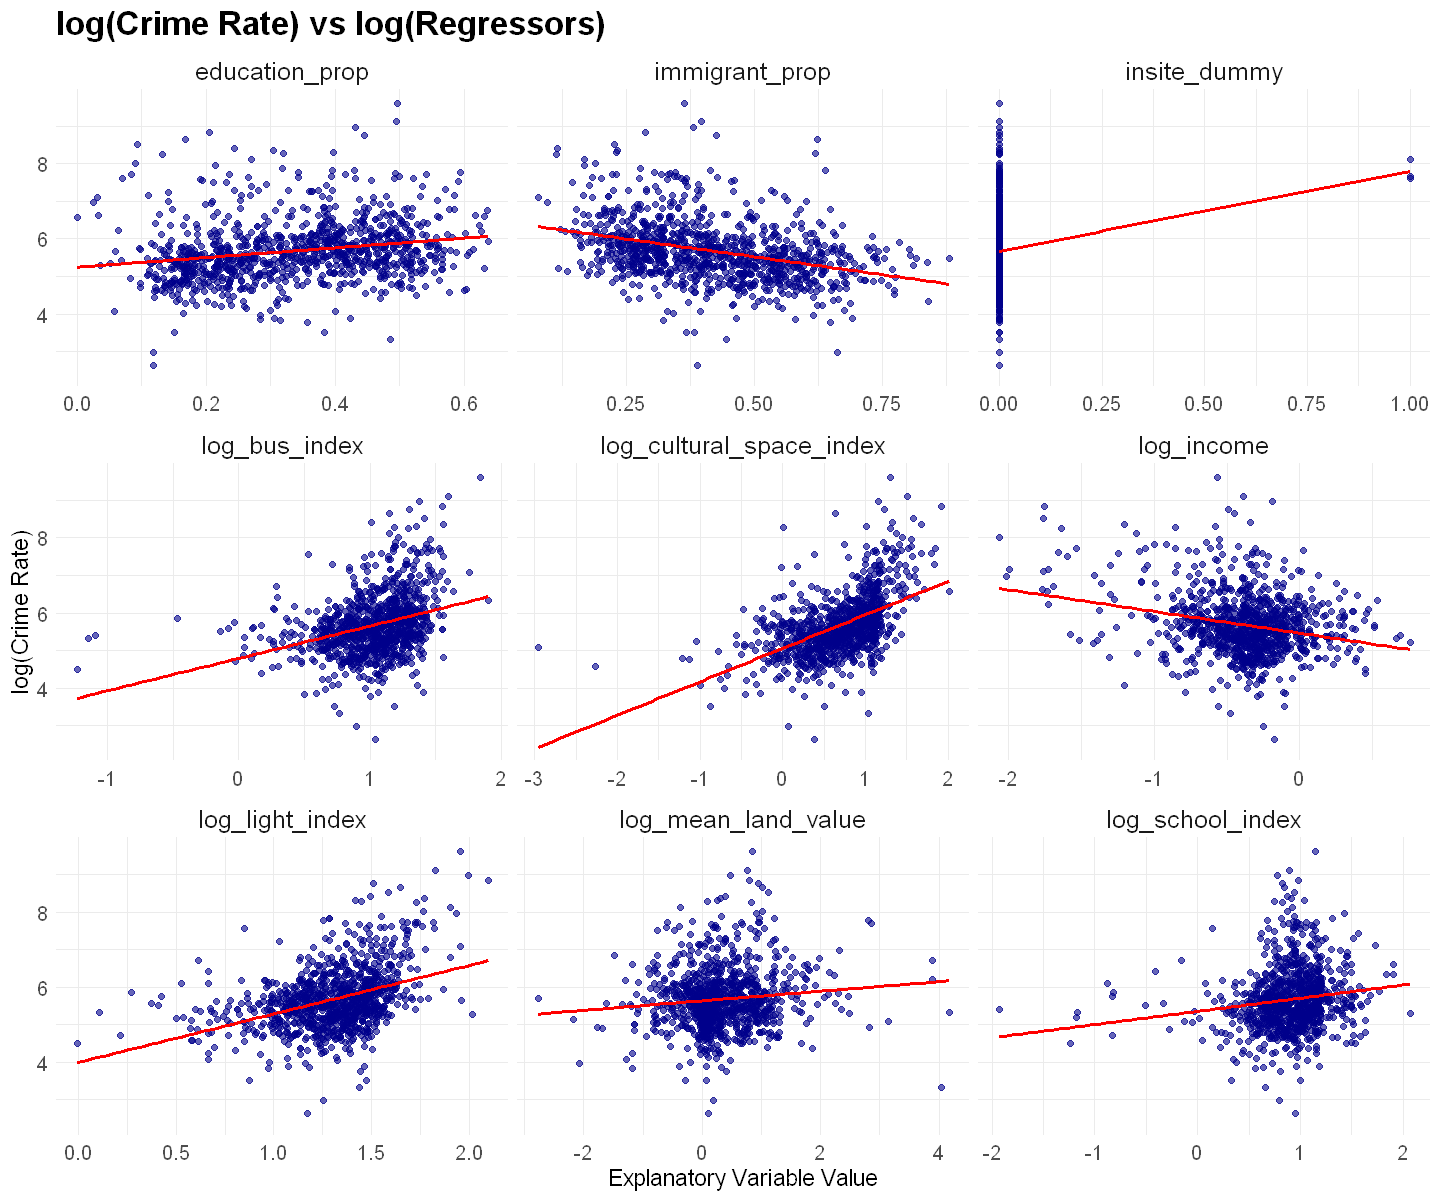

In [57]:
regressors <- c('log_mean_land_value','log_school_index', 'log_light_index', 'log_bus_index', 'log_cultural_space_index', 
                'log_income', 'immigrant_prop', 'education_prop','insite_dummy')

long_data <- census_index_crime_log_st |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

log_log_variables_scatter <- ggplot(long_data, aes(x = value, y = log_crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "log(Crime Rate) vs log(Regressors)",
       x = "Explanatory Variable Value",
       y = "log(Crime Rate)") +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

log_log_variables_scatter

In [58]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
# For this model we add insite_dummy
reg_log3 <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index +
              log_cultural_space_index + log_income + immigrant_prop + education_prop + insite_dummy,  
              data = census_index_crime_log_st)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log3, ~ fitted(reg_log3) + I(fitted(reg_log3)^2), data = census_index_crime_log)
print(white_test)

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  reg_log_robust3 <- coeftest(reg_log3, vcov = vcovHC(reg_log3, type = "HC1"))
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust3)
  
  # Extract robust standard errors
  robust_se3 <- sqrt(diag(vcovHC(reg_log3, type = "HC1")))
} else {
  print("No significant heteroskedasticity detected.")
  
  # Use regular standard errors
  robust_se3 <- coef(summary(reg_log3))[, "Std. Error"]
}

# Generate a regression table with stargazer
stargazer(reg_log3, type = "text", 
          title = "Log-Log Regression Results", 
          dep.var.labels = c("Log Crime Rate"),
          ci=FALSE, 
          single.row=TRUE)

# Add robust standard errors if heteroskedasticity was detected
if (white_test$p.value < 0.05) {
  stargazer(reg_log3, type = "text", 
            title = "Log-Log Regression Results with Robust Standard Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se3),
            single.row=TRUE)
}


	studentized Breusch-Pagan test

data:  reg_log3
BP = 37.412, df = 2, p-value = 7.519e-09

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)               4.099085   0.198635 20.6363 < 2.2e-16 ***
log_mean_land_value       0.162172   0.042165  3.8462 0.0001277 ***
log_school_index         -0.580283   0.099096 -5.8558 6.473e-09 ***
log_light_index           1.291024   0.176352  7.3207 5.135e-13 ***
log_cultural_space_index  0.428064   0.089405  4.7879 1.945e-06 ***
log_income               -0.425650   0.069002 -6.1686 1.006e-09 ***
immigrant_prop           -0.791536   0.173697 -4.5570 5.843e-06 ***
education_prop            0.726326   0.211508  3.4340 0.0006196 ***
insite_dummy              0.995092   0.169254  5.8793 5.645e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Log-Log Regression Results
                             Dependent va

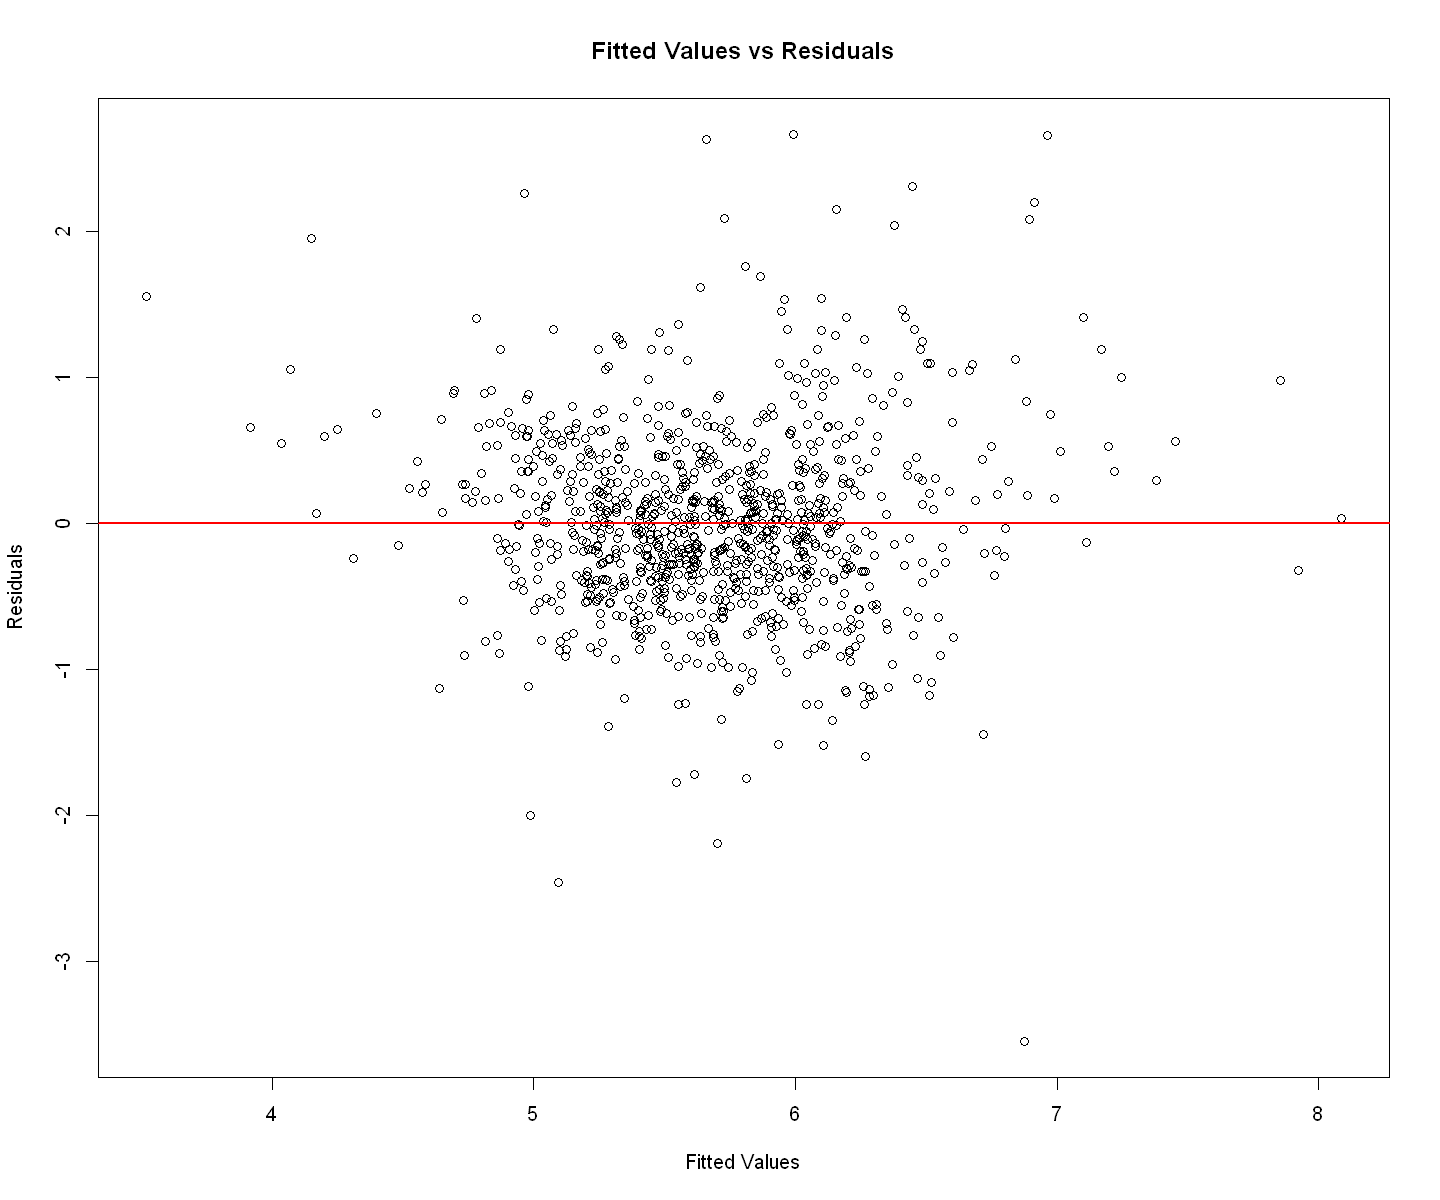

In [59]:
# Plot fitted values vs residuals
plot(fitted(reg_log3), residuals(reg_log3), 
     xlab = "Fitted Values", ylab = "Residuals",
     main = "Fitted Values vs Residuals")

# Add a horizontal line at 0 to assess heteroskedasticity
abline(h = 0, col = "red", lwd = 2)


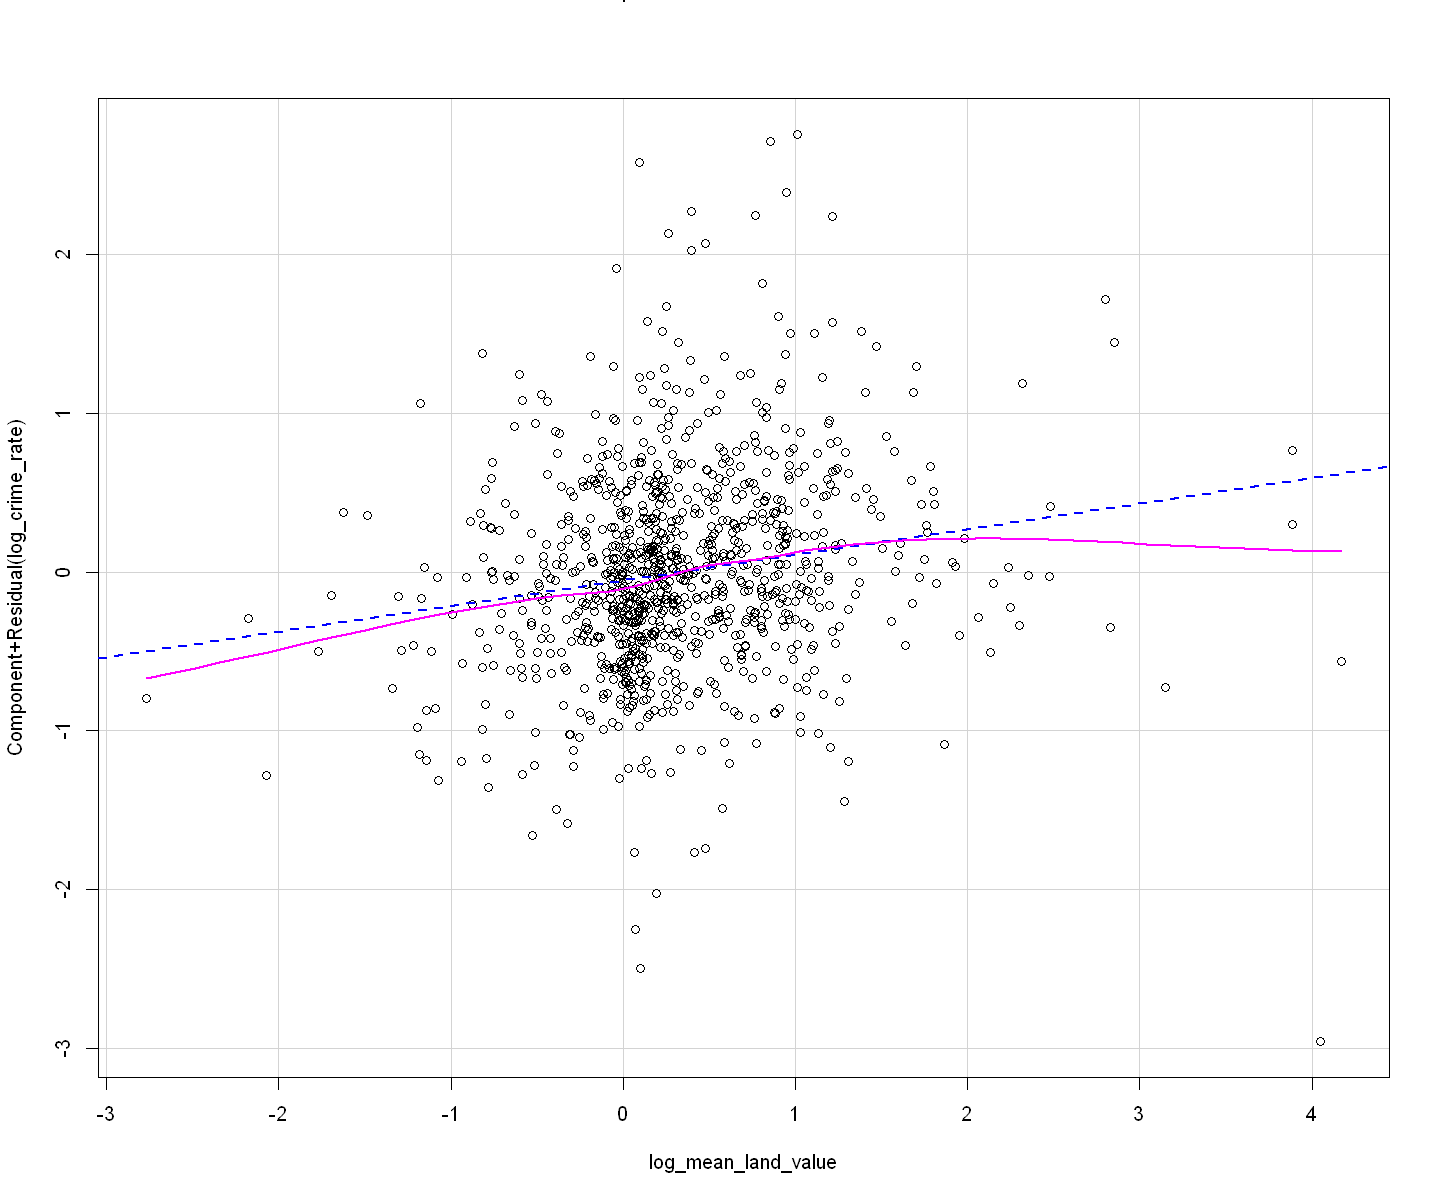

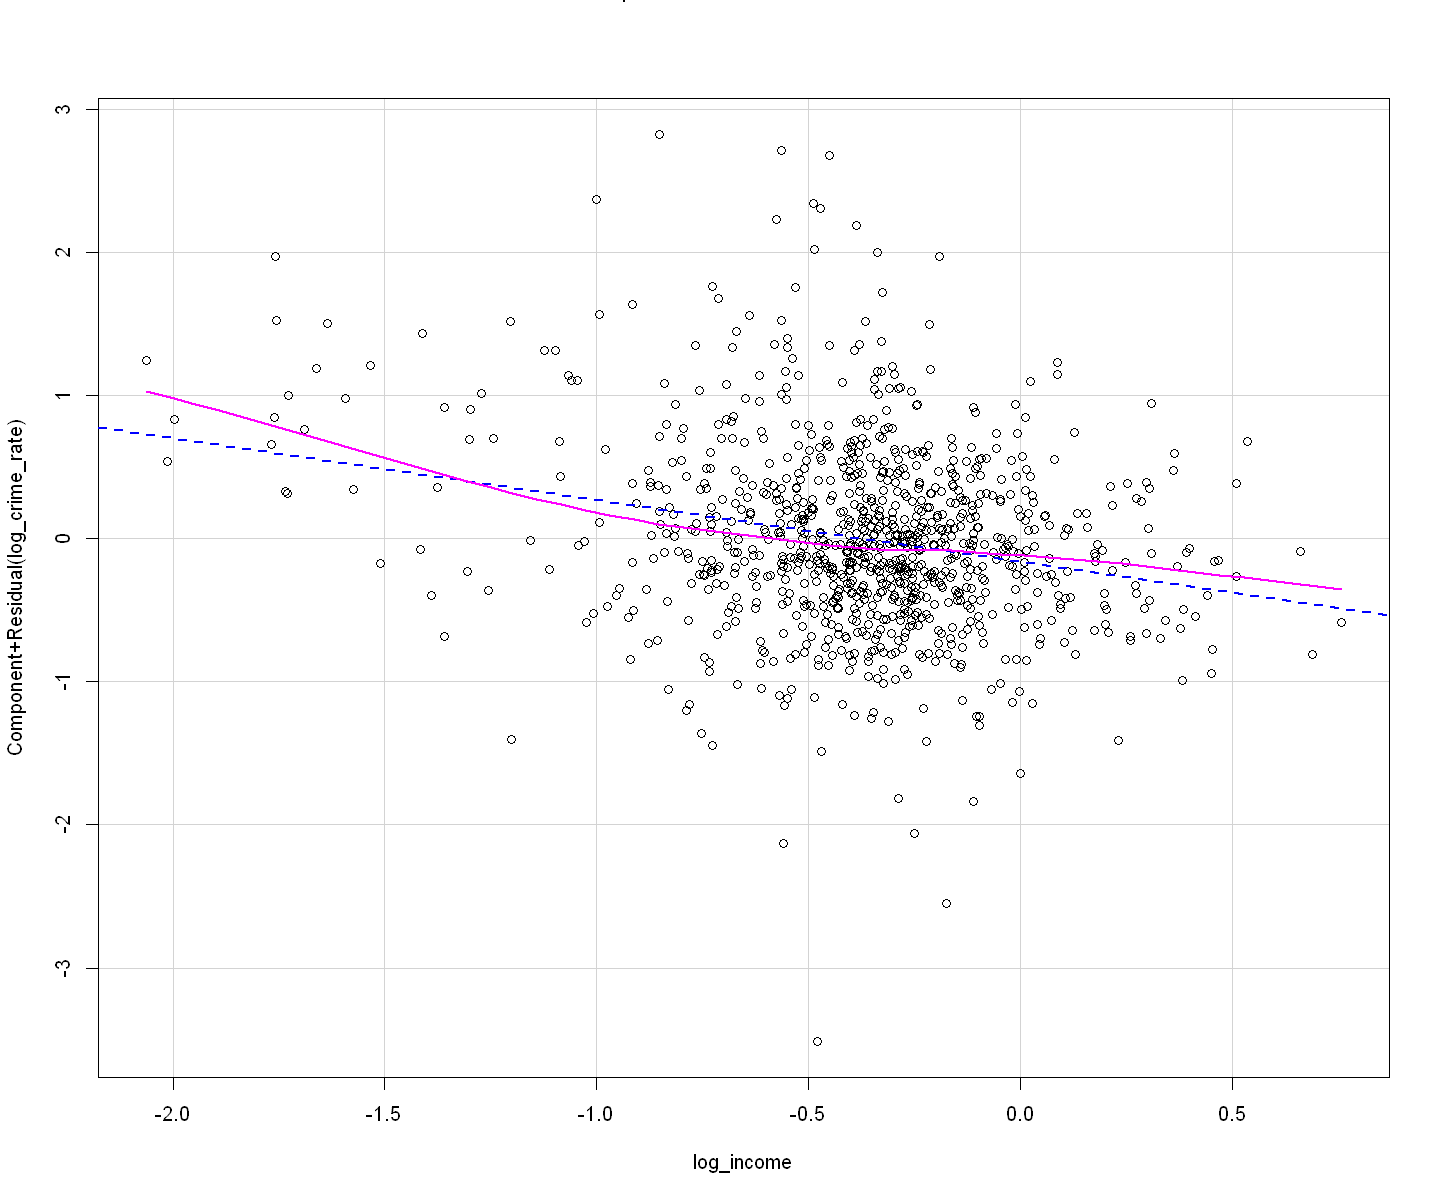

In [60]:
# Partial regression plot for log_mean_land_value
crPlots(reg_log2, terms = ~ log_mean_land_value)

# Partial regression plot for log_income
crPlots(reg_log2, terms = ~ log_income)

In [61]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
# For this model we create interaction terms of education_prop and immigrant_prop
reg_log4 <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + log_cultural_space_index
               + log_income + immigrant_prop + education_prop + insite_dummy + immigrant_prop:education_prop,  
              data = census_index_crime_log_st)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log4, ~ fitted(reg_log4) + I(fitted(reg_log4)^2), data = census_index_crime_log)
print(white_test)

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  reg_log_robust4 <- coeftest(reg_log4, vcov = vcovHC(reg_log4, type = "HC1"))
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust4)
  
  # Extract robust standard errors
  robust_se4 <- sqrt(diag(vcovHC(reg_log4, type = "HC1")))
} else {
  print("No significant heteroskedasticity detected.")
  
  # Use regular standard errors
  robust_se4 <- coef(summary(reg_log4))[, "Std. Error"]
}

# Generate a regression table with stargazer
stargazer(reg_log4, type = "text", 
          title = "Log-Log Regression Results", 
          dep.var.labels = c("Log Crime Rate"),
          ci=FALSE, 
          single.row=TRUE)

# Add robust standard errors if heteroskedasticity was detected
if (white_test$p.value < 0.05) {
  stargazer(reg_log4, type = "text", 
            title = "Log-Log Regression Results with Robust Standard Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se4),
            single.row=TRUE)}


	studentized Breusch-Pagan test

data:  reg_log4
BP = 33.72, df = 2, p-value = 4.761e-08

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                               Estimate Std. Error t value  Pr(>|t|)    
(Intercept)                    4.448181   0.271991 16.3542 < 2.2e-16 ***
log_mean_land_value            0.156643   0.042202  3.7117 0.0002175 ***
log_school_index              -0.562650   0.099428 -5.6589 2.000e-08 ***
log_light_index                1.261939   0.178119  7.0848 2.659e-12 ***
log_cultural_space_index       0.430143   0.089019  4.8320 1.568e-06 ***
log_income                    -0.409982   0.068645 -5.9725 3.266e-09 ***
immigrant_prop                -1.525080   0.390770 -3.9028 0.0001016 ***
education_prop                -0.224612   0.501836 -0.4476 0.6545552    
insite_dummy                   0.948874   0.191892  4.9448 8.964e-07 ***
immigrant_prop:education_prop  2.307202   1.105177  2.0876 0.0370892 *  
---
Signif. cod

In [62]:
  stargazer(reg_log2, reg_log3, reg_log4, type = "text", 
            title = "Log-Log Regression Results with Robust Standard Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se2, robust_se3, robust_se4),
            single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                                                        Dependent variable:                          
                              -----------------------------------------------------------------------
                                                          Log Crime Rate                             
                                        (1)                     (2)                     (3)          
-----------------------------------------------------------------------------------------------------
log_mean_land_value              0.161*** (0.042)        0.162*** (0.042)        0.157*** (0.042)    
log_school_index                 -0.602*** (0.099)       -0.580*** (0.099)       -0.563*** (0.099)   
log_light_index                  1.329*** (0.175)        1.291*** (0.176)        1.262*** (0.178)    
log_cultural_space_index         0.430*** (0.090)        0.428*** (0.089)        0.430*** (0.089)    
log_income                

In [63]:
reg_log5 <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + log_cultural_space_index
               + log_income + immigrant_prop + insite_dummy + immigrant_prop:education_prop,  
              data = census_index_crime_log_st)

robust_se5 <- sqrt(diag(vcovHC(reg_log5, type = "HC1")))

stargazer(reg_log5, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se5),
        single.row=TRUE)



Log-Log Regression Results with Robust Standard Errors
                                  Dependent variable:    
                              ---------------------------
                                    Log Crime Rate       
---------------------------------------------------------
log_mean_land_value                0.158*** (0.042)      
log_school_index                   -0.564*** (0.099)     
log_light_index                    1.271*** (0.174)      
log_cultural_space_index           0.425*** (0.087)      
log_income                         -0.418*** (0.066)     
immigrant_prop                     -1.371*** (0.198)     
insite_dummy                       0.961*** (0.186)      
immigrant_prop:education_prop      1.841*** (0.465)      
Constant                           4.359*** (0.155)      
---------------------------------------------------------
Observations                              989            
R2                                       0.405           
Adjusted R2     

In [64]:
vif(reg_log5)|> tidy()

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif

Warning message in tidy.numeric(vif(reg_log5)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_mean_land_value,1.042879
log_school_index,2.161426
log_light_index,2.673691
log_cultural_space_index,2.850624
log_income,1.257834
immigrant_prop,2.034631
insite_dummy,1.027825
immigrant_prop:education_prop,1.576020


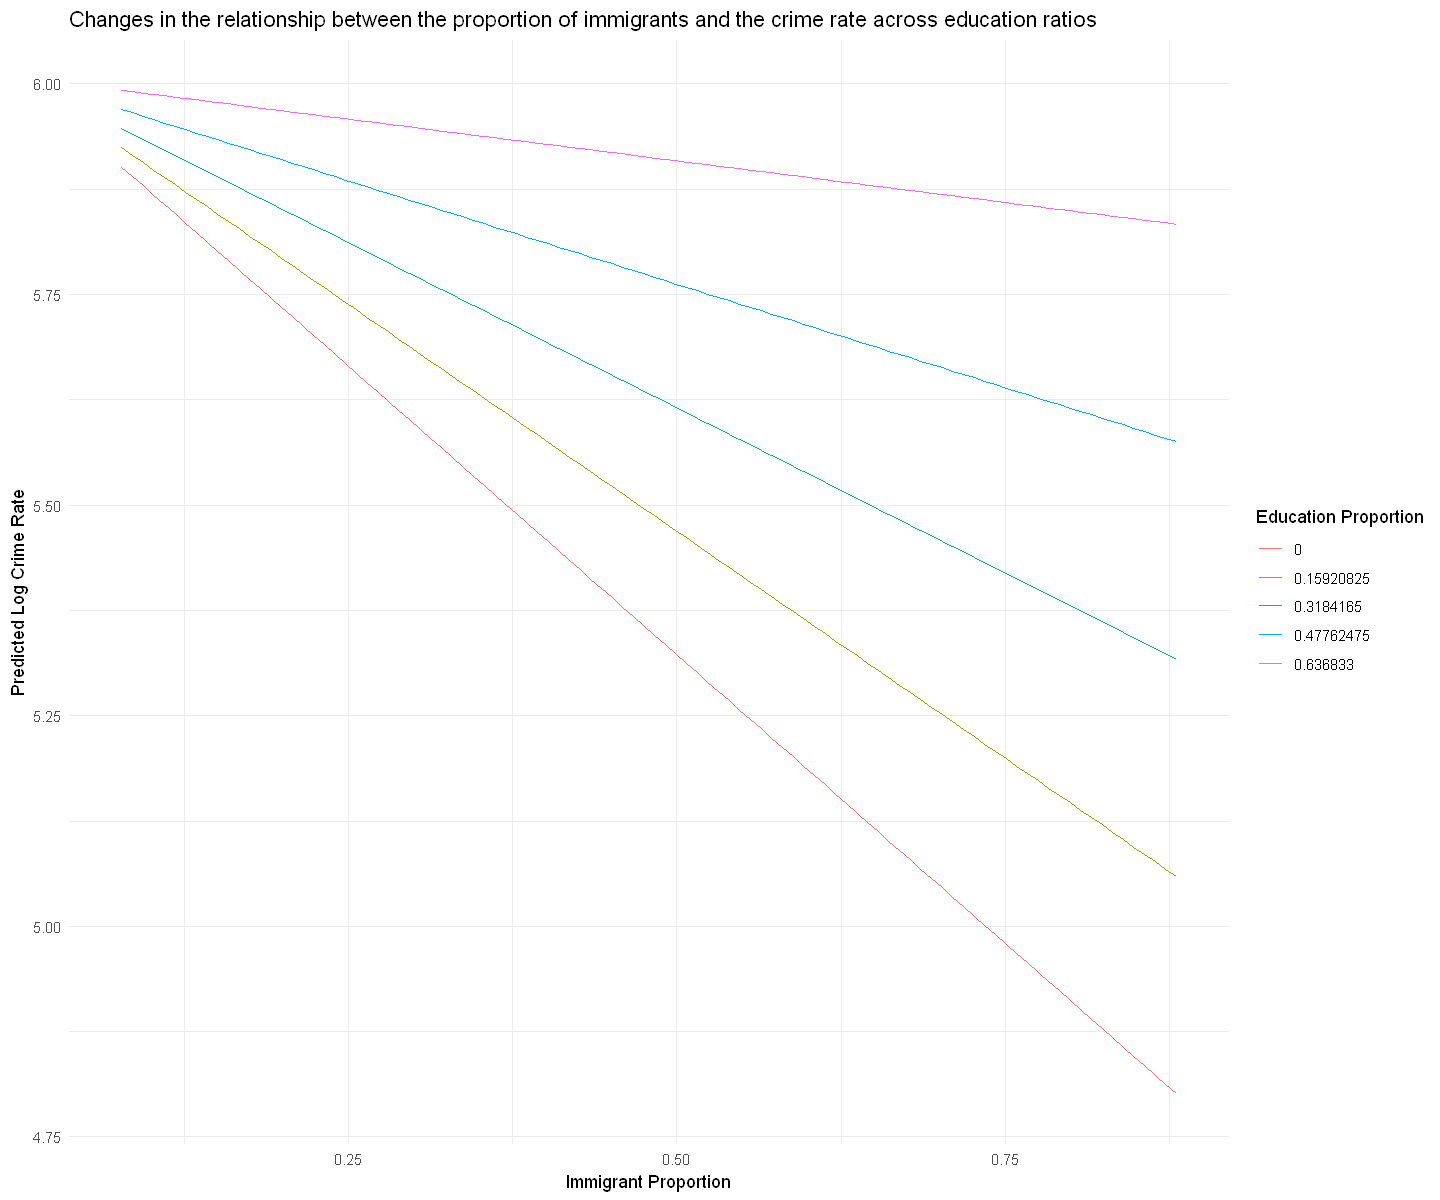

In [65]:
education_levels <- seq(min(census_index_crime_log_st$education_prop), 
                        max(census_index_crime_log_st$education_prop), length.out = 5)
immigrant_levels <- seq(min(census_index_crime_log_st$immigrant_prop), 
                        max(census_index_crime_log_st$immigrant_prop), length.out = 100)
plot_data <- expand.grid(education_prop = education_levels, 
                         immigrant_prop = immigrant_levels)

plot_data$pred_log_crime_rate <- 4.35911 + 
  0.15751 * mean(census_index_crime_log_st$log_mean_land_value) +
  (-0.56388) * mean(census_index_crime_log_st$log_school_index) +
  1.27117 * mean(census_index_crime_log_st$log_light_index) +
  0.42509 * mean(census_index_crime_log_st$log_cultural_space_index) +
  (-0.41789) * mean(census_index_crime_log_st$log_income) +
  (-1.37070) * plot_data$immigrant_prop +
  0.96127 * mean(census_index_crime_log_st$insite_dummy) +
  1.84146 * plot_data$immigrant_prop * plot_data$education_prop

ggplot(plot_data, aes(x = immigrant_prop, y = pred_log_crime_rate, color = as.factor(education_prop))) +
  geom_line() +
  labs(title = "Changes in the relationship between the proportion of immigrants and the crime rate across education ratios",
       x = "Immigrant Proportion",
       y = "Predicted Log Crime Rate",
       color = "Education Proportion") +
  theme_minimal()

In [66]:
# Pull unemployment census data and calculate the unemployment rate
library(cancensus)
options(cancensus.api_key='CensusMapper_f228791d9506a7a747ece66db73b95be')
options(cancensus.cache_path = "/cache")
census_data_unemployed <- get_census(dataset='CA16', regions=list(CSD="5915022"), vectors=c("v_CA16_5600","v_CA16_5606"), labels="detailed", geo_format= 'sf', level='DA')|>
    mutate(unemployment_rate = `v_CA16_5606: Unemployed`/`v_CA16_5600: In the labour force`)|>
    rename(name = GeoUID)|>
    select(name, unemployment_rate)|>
    st_drop_geometry()

glimpse(census_data_unemployed)

Warning message:
"package 'cancensus' was built under R version 4.4.2"
Census data is currently stored temporarily.

 In order to speed up performance, reduce API quota usage, and reduce unnecessary network calls, please set up a persistent cache directory via `set_cancensus_cache_path('<local cache path>', install = TRUE)`.
 This will add your cache directory as environment varianble to your .Renviron to be used across sessions and projects.



Reading vectors data from local cache.

Reading geo data from local cache.



Rows: 993
Columns: 2
$ name              <chr> "59150307", "59150308", "59150309", "59150310", "591…
$ unemployment_rate <dbl> 0.07228916, 0.10937500, 0.00000000, 0.05769231, 0.02…


In [67]:
# Merge two dataset
census_index_crime_log_st <- merge(census_index_crime_log_st, census_data_unemployed, by = "name") |>
    mutate(unemployment_rate = ifelse(is.na(unemployment_rate) | is.nan(unemployment_rate), 0, unemployment_rate)) |>
    glimpse()

Rows: 989
Columns: 31
$ name                     <chr> "59150307", "59150308", "59150309", "59150310…
$ households               <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, …
$ dwellings                <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, …
$ population               <int> 632, 501, 745, 536, 532, 562, 1088, 556, 959,…
$ population_density       <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.…
$ region                   <chr> "Vancouver", "Vancouver", "Vancouver", "Vanco…
$ area_sq_km               <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, …
$ age                      <int> 630, 500, 745, 540, 530, 560, 1085, 555, 960,…
$ income                   <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, …
$ immigrant_prop           <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0…
$ education_prop           <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0…
$ school_index             <dbl> 1.074675, 1.252273, 1.426336, 2.441091, 1.543…
$ light_index     

In [68]:

mean(census_index_crime_log_st$unemployment_rate)

[1] 0.05799239

In [69]:
reg_log6 <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + log_cultural_space_index
               + log_income + immigrant_prop + education_prop + insite_dummy + unemployment_rate ,  
              data = census_index_crime_log_st)

robust_se6 <- sqrt(diag(vcovHC(reg_log6, type = "HC1")))

stargazer(reg_log6, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se6),
        single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_mean_land_value           0.159*** (0.043)      
log_school_index              -0.576*** (0.099)     
log_light_index               1.294*** (0.175)      
log_cultural_space_index      0.427*** (0.090)      
log_income                    -0.406*** (0.072)     
immigrant_prop                -0.804*** (0.175)     
education_prop                0.740*** (0.212)      
insite_dummy                  0.985*** (0.184)      
unemployment_rate               0.879 (0.705)       
Constant                      4.050*** (0.200)      
----------------------------------------------------
Observations                         989            
R2                                  0.403           
Adjusted R2                         0.398  

In [70]:
vif(reg_log6)|>tidy()

Warning message in tidy.numeric(vif(reg_log6)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_mean_land_value,1.043683
log_school_index,2.144130
log_light_index,2.709519
log_cultural_space_index,2.924303
log_income,1.398906
immigrant_prop,1.532854
education_prop,1.644757
insite_dummy,1.030148
unemployment_rate,1.080337


In [71]:
stargazer(reg_log2,reg_log3, reg_log4, reg_log5, reg_log6, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se2, robust_se3, robust_se4, robust_se5, robust_se6),
        single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                                                                                Dependent variable:                                                  
                              -----------------------------------------------------------------------------------------------------------------------
                                                                                  Log Crime Rate                                                     
                                        (1)                     (2)                     (3)                     (4)                     (5)          
-----------------------------------------------------------------------------------------------------------------------------------------------------
log_mean_land_value              0.161*** (0.042)        0.162*** (0.042)        0.157*** (0.042)        0.158*** (0.042)        0.159*** (0.043)    
log_school_index                 -0.602*** (

Everything below this cell are the ideas of ChatGPT, for reference only.

In [72]:
reg_log7 <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + log_cultural_space_index
               + log_income + immigrant_prop + education_prop + insite_dummy + unemployment_rate  
               + log_light_index:log_mean_land_value + log_school_index:education_prop, 
              data = census_index_crime_log_st)

robust_se7 <- sqrt(diag(vcovHC(reg_log7, type = "HC1")))

stargazer(reg_log7, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se7),
        single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                                        Dependent variable:    
                                    ---------------------------
                                          Log Crime Rate       
---------------------------------------------------------------
log_mean_land_value                       -0.236* (0.142)      
log_school_index                         -1.060*** (0.212)     
log_light_index                          1.094*** (0.167)      
log_cultural_space_index                 0.513*** (0.090)      
log_income                               -0.363*** (0.072)     
immigrant_prop                           -0.741*** (0.176)     
education_prop                            -0.295 (0.522)       
insite_dummy                             1.045*** (0.186)      
unemployment_rate                         1.165* (0.695)       
log_mean_land_value:log_light_index      0.312*** (0.119)      
log_school_index:education_prop           1.081*

In [73]:
vif(reg_log7)|>tidy()

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif

Warning message in tidy.numeric(vif(reg_log7)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_mean_land_value,22.717201
log_school_index,14.859882
log_light_index,3.179610
log_cultural_space_index,3.216104
log_income,1.448968
immigrant_prop,1.547858
education_prop,13.158397
insite_dummy,1.032716
unemployment_rate,1.097281


In [74]:
census_index_crime_log_st_centered <- census_index_crime_log_st %>%
  mutate(
    log_mean_land_value_c = log_mean_land_value - mean(log_mean_land_value, na.rm = TRUE),
    log_light_index_c = log_light_index - mean(log_light_index, na.rm = TRUE),
    log_school_index_c = log_school_index - mean(log_school_index, na.rm = TRUE),
    education_prop_c = education_prop - mean(education_prop, na.rm = TRUE),
    unemployment_rate_c = unemployment_rate - mean(unemployment_rate, na.rm = TRUE),
    interaction1 = log_mean_land_value_c * log_light_index_c,
    interaction2 = log_school_index_c * education_prop_c,
    interaction3 = unemployment_rate_c * education_prop_c
  )

reg_log7_centered <- lm(
  log_crime_rate ~ log_mean_land_value_c + log_school_index_c + log_light_index_c + log_cultural_space_index +
    log_income + immigrant_prop + education_prop_c + insite_dummy + interaction1 + interaction2,
  data = census_index_crime_log_st_centered
)

robust_se7_centered <- sqrt(diag(vcovHC(reg_log7_centered, type = "HC1")))

stargazer(reg_log7_centered, type = "text", 
          title = "Log-Log Regression Results with Centered Variables and Robust Standard Errors", 
          dep.var.labels = c("Log Crime Rate"), 
          se = list(robust_se7_centered),
          single.row = TRUE)

vif_values_centered <- vif(reg_log7_centered)
print(vif_values_centered)


Log-Log Regression Results with Centered Variables and Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_mean_land_value_c         0.175*** (0.044)      
log_school_index_c            -0.696*** (0.106)     
log_light_index_c             1.196*** (0.169)      
log_cultural_space_index      0.510*** (0.090)      
log_income                    -0.391*** (0.069)     
immigrant_prop                -0.729*** (0.175)     
education_prop_c              0.675*** (0.209)      
insite_dummy                  1.054*** (0.166)      
interaction1                   0.290** (0.121)      
interaction2                   1.045** (0.505)      
Constant                      5.490*** (0.114)      
----------------------------------------------------
Observations                         989            
R2                  

Warning message:
"glm.fit: algorithm did not converge"
Warning message in glm.nb(formula = crime_count ~ log_mean_land_value + log_school_index + :
"alternation limit reached"


[1] "Poisson Dispersion: 75.4707042252901"
     log_mean_land_value         log_school_index          log_light_index 
                1.054178                 1.581301                 2.379779 
log_cultural_space_index               log_income           immigrant_prop 
                3.446820                 2.579287                 1.464471 
          education_prop             insite_dummy        unemployment_rate 
                1.965585                 1.083221                 1.337057 


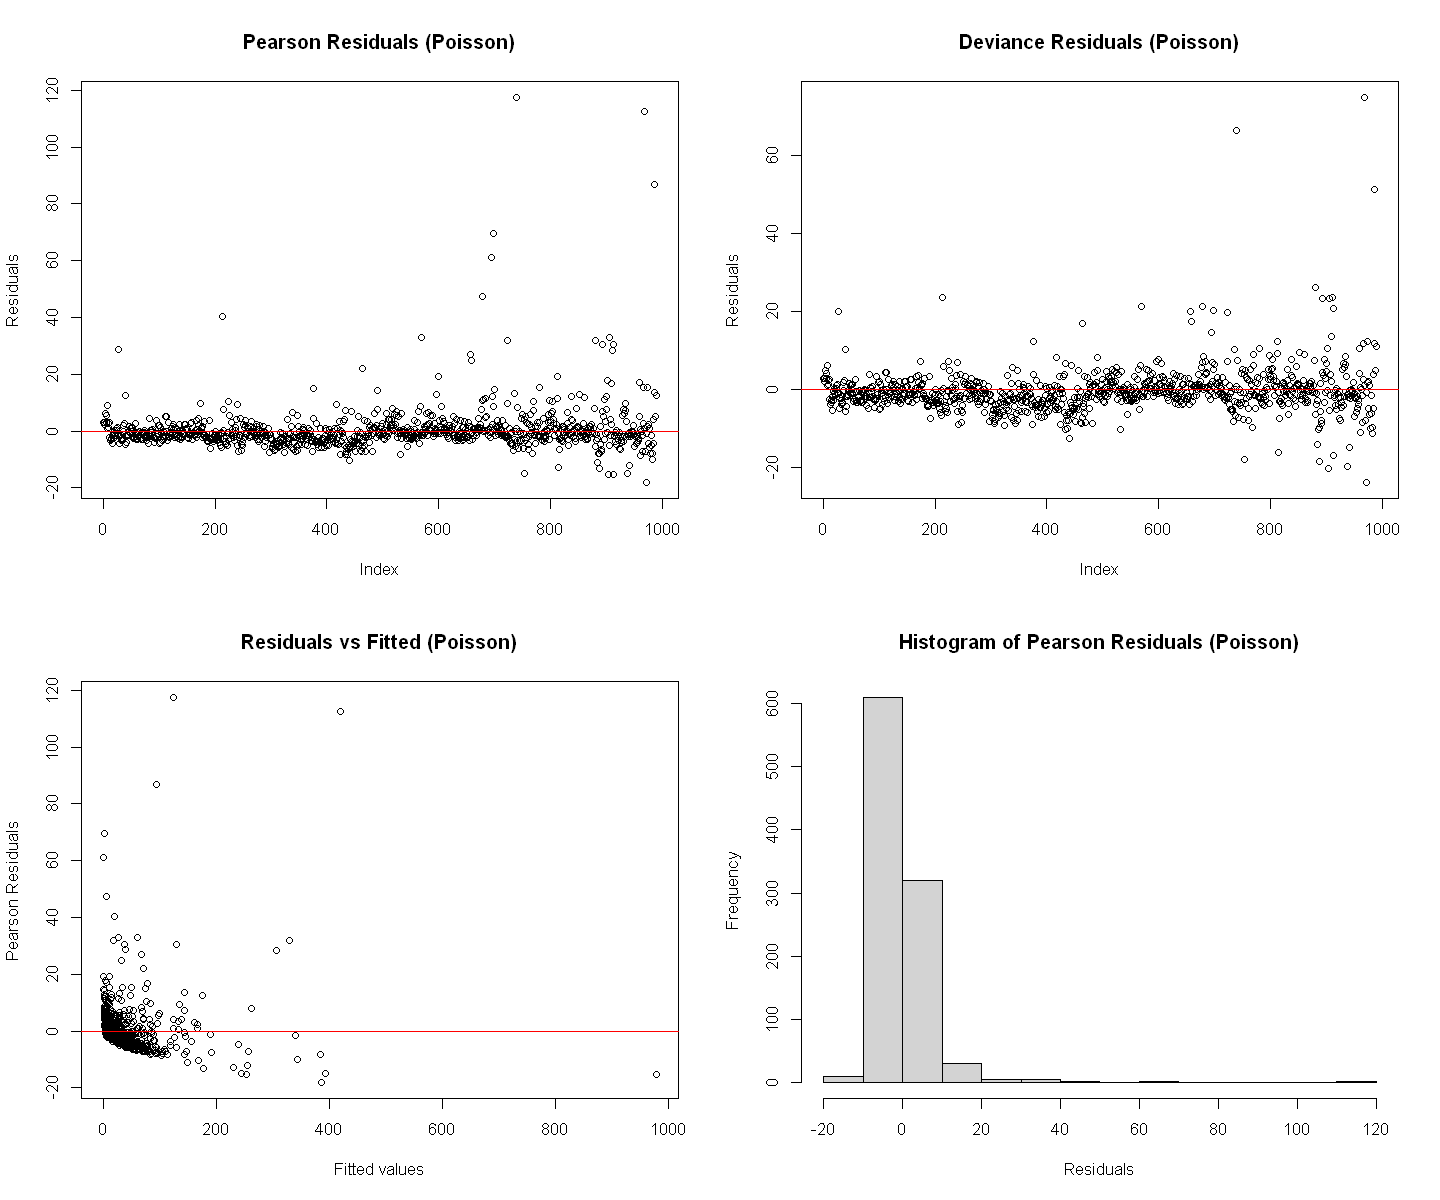

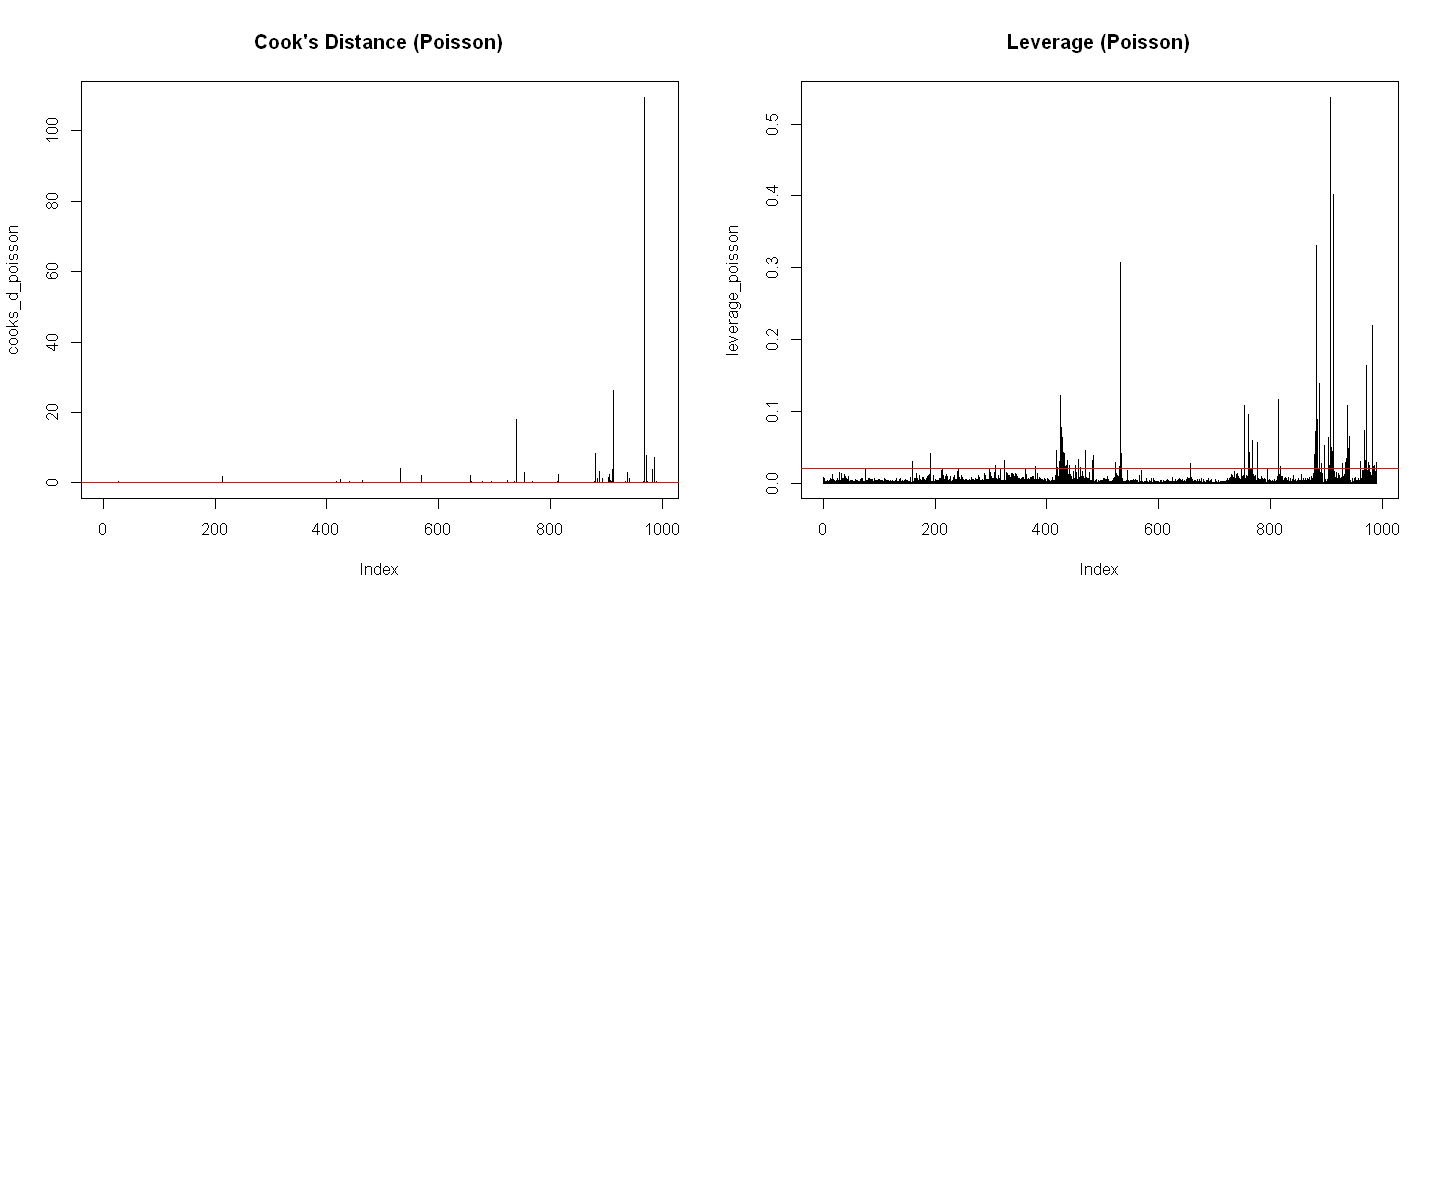

In [76]:
# 泊松回归模型
poisson_model <- glm(formula = crime_count ~ log_mean_land_value + log_school_index + 
                      log_light_index + log_cultural_space_index + log_income + 
                      immigrant_prop + education_prop + insite_dummy + unemployment_rate, 
                      family = poisson(link = "log"), data = census_index_crime_log_st)

# 负二项回归模型
neg_binom_model <- glm.nb(formula = crime_count ~ log_mean_land_value + log_school_index + 
                            log_light_index + log_cultural_space_index + log_income + 
                            immigrant_prop + education_prop + insite_dummy + unemployment_rate, 
                            data = census_index_crime_log_st, init.theta = 1.654009416, link = log)

# 1. 过度离散性检测
dispersion_poisson <- sum(residuals(poisson_model, type = "pearson")^2) / poisson_model$df.residual
print(paste("Poisson Dispersion:", dispersion_poisson))

# 2. 残差分析
par(mfrow = c(2, 2))
plot(residuals(poisson_model, type = "pearson"), main = "Pearson Residuals (Poisson)", ylab = "Residuals")
abline(h = 0, col = "red")
plot(residuals(poisson_model, type = "deviance"), main = "Deviance Residuals (Poisson)", ylab = "Residuals")
abline(h = 0, col = "red")
plot(fitted(poisson_model), residuals(poisson_model, type = "pearson"), main = "Residuals vs Fitted (Poisson)", xlab = "Fitted values", ylab = "Pearson Residuals")
abline(h = 0, col = "red")
hist(residuals(poisson_model, type = "pearson"), main = "Histogram of Pearson Residuals (Poisson)", xlab = "Residuals")

# 3. 影响点检测
cooks_d_poisson <- cooks.distance(poisson_model)
plot(cooks_d_poisson, type = "h", main = "Cook's Distance (Poisson)")
abline(h = 4/(length(cooks_d_poisson) - length(coef(poisson_model))), col = "red")

leverage_poisson <- hatvalues(poisson_model)
plot(leverage_poisson, type = "h", main = "Leverage (Poisson)")
abline(h = 2*mean(leverage_poisson), col = "red")

# 4. 多重共线性检测
vif_poisson <- vif(poisson_model)
print(vif_poisson)
